In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import datetime

import statsmodels.tsa.api as smt

In [3]:
sales_data = pd.read_csv('train.csv',parse_dates=['date'])


In [4]:
sales_data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [5]:
def monthly_sales(data):
    monthly_data = data.copy()
    monthly_data.date = monthly_data.date.apply(lambda x: str(x)[:-3])
    monthly_data = monthly_data.groupby('date')['sales'].sum().reset_index()
    monthly_data.date = pd.to_datetime(monthly_data.date)
    return monthly_data

In [6]:
monthly_df = monthly_sales(sales_data)
monthly_df.head()

,date,sales
0,2013-01-01,13696
1,2013-01-02,13678
2,2013-01-03,14488
3,2013-01-04,15677
4,2013-01-05,16237


In [7]:
# Duration of dataset
def sales_duration(data):
    data.date = pd.to_datetime(data.date)
    number_of_days = data.date.max() - data.date.min()
    number_of_years = number_of_days.days / 365
    print(number_of_days.days, 'days')
    print(number_of_years, 'years')
    
sales_duration(sales_data)

1825 days
5.0 years


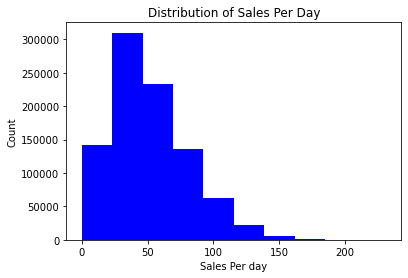

In [8]:
def sales_per_day():
    fig, ax = plt.subplots()
    plt.hist(sales_data.sales, color='blue')
    
    ax.set(xlabel = "Sales Per day",
           ylabel = "Count",
           title = "Distribution of Sales Per Day")
    
sales_per_day()

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


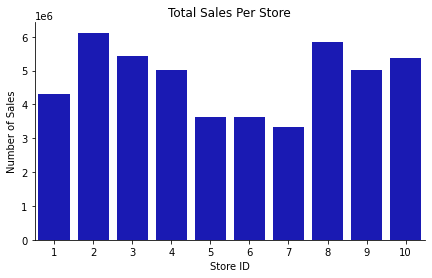

In [9]:
def sales_per_store():
    by_store = sales_data.groupby('store')['sales'].sum().reset_index()
    
    fig, ax = plt.subplots(figsize=(7,4))
    sns.barplot(by_store.store, by_store.sales, color='mediumblue')
    
    ax.set(xlabel = "Store ID",
           ylabel = "Number of Sales",
           title = "Total Sales Per Store")
    
    sns.despine()
    
sales_per_store()

In [10]:
# Average monthly sales

# Overall
avg_monthly_sales = monthly_df.sales.mean()
print(f"Overall average monthly sales: ${avg_monthly_sales}")

# Last 12 months (this will be the forecasted sales)
avg_monthly_sales_12month = monthly_df.sales[-12:].mean()
print(f"Last 12 months average monthly sales: ${avg_monthly_sales_12month}")

Overall average monthly sales: $26125.143483023003
Last 12 months average monthly sales: $22723.333333333332


In [11]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

In [12]:
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x_col, y_col, data=data, ax=ax, color='mediumblue', label='Total Sales')
    
    second = data.groupby(data.date.dt.year)[y_col].mean().reset_index()
    second.date = pd.to_datetime(second.date, format='%Y')
    sns.lineplot((second.date + datetime.timedelta(6*365/12)), y_col, data=second, ax=ax, color='red', label='Mean Sales')   
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = title)
    
    sns.despine()

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


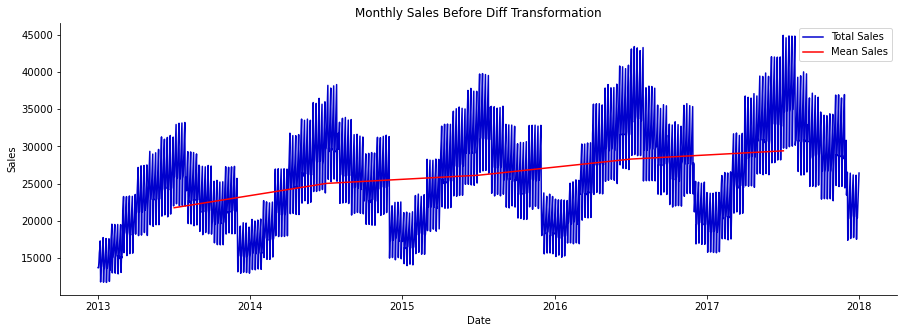

In [13]:
time_plot(monthly_df, 'date', 'sales', 'Monthly Sales Before Diff Transformation')

In [14]:
def get_diff(data):
    data['sales_diff'] = data.sales.diff()
    data = data.dropna()
    
    data.to_csv('stationary_df.csv')
    return data

In [15]:
stationary_df = get_diff(monthly_df)

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


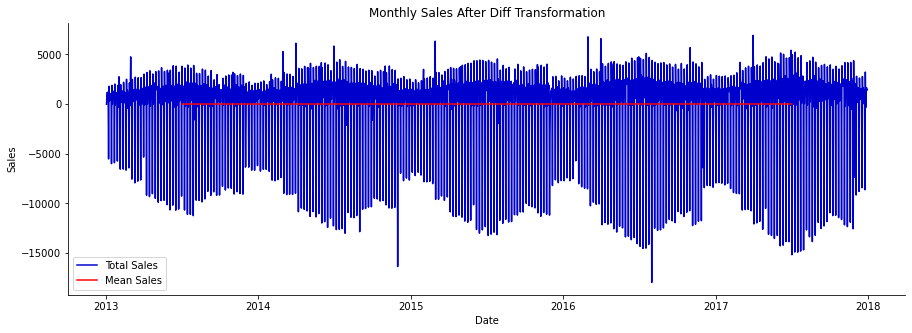

In [16]:
time_plot(stationary_df, 'date', 'sales_diff', 'Monthly Sales After Diff Transformation')

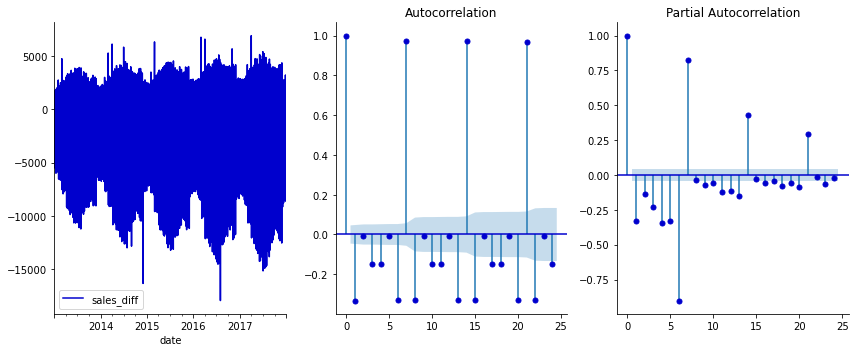

In [17]:
def plots(data, lags=None):
    
    # Convert dataframe to datetime index
    dt_data = data.set_index('date').drop('sales', axis=1)
    dt_data.dropna(axis=0)
    
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    dt_data.plot(ax=raw, figsize=(12, 5), color='mediumblue')
    smt.graphics.plot_acf(dt_data, lags=lags, ax=acf, color='mediumblue')
    smt.graphics.plot_pacf(dt_data, lags=lags, ax=pacf, color='mediumblue')
    sns.despine()
    plt.tight_layout()

plots(stationary_df, lags=24);

In [18]:
#create dataframe for transformation from time series to supervised
def generate_supervised(data):
    supervised_df = data.copy()
    
    #create column for each lag
    for i in range(1,13):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['sales_diff'].shift(i)
    
    #drop null values
    supervised_df = supervised_df.dropna().reset_index(drop=True)
    
    supervised_df.to_csv('model_df.csv', index=False)
    
    return supervised_df

In [19]:
model_df = generate_supervised(stationary_df)

In [20]:
model_df

,date,sales,sales_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2013-01-14,11746,-5995.0,1062.0,1046.0,991.0,764.0,318.0,1791.0,-5522.0,1054.0,560.0,1189.0,810.0,-18.0
1,2013-01-15,13625,1879.0,-5995.0,1062.0,1046.0,991.0,764.0,318.0,1791.0,-5522.0,1054.0,560.0,1189.0,810.0
2,2013-01-16,13591,-34.0,1879.0,-5995.0,1062.0,1046.0,991.0,764.0,318.0,1791.0,-5522.0,1054.0,560.0,1189.0
3,2013-01-17,14587,996.0,-34.0,1879.0,-5995.0,1062.0,1046.0,991.0,764.0,318.0,1791.0,-5522.0,1054.0,560.0
4,2013-01-18,15495,908.0,996.0,-34.0,1879.0,-5995.0,1062.0,1046.0,991.0,764.0,318.0,1791.0,-5522.0,1054.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1808,2017-12-27,20378,-360.0,3221.0,-8613.0,1367.0,1196.0,1353.0,1669.0,28.0,2771.0,-8421.0,1214.0,1372.0,1544.0
1809,2017-12-28,21885,1507.0,-360.0,3221.0,-8613.0,1367.0,1196.0,1353.0,1669.0,28.0,2771.0,-8421.0,1214.0,1372.0
1810,2017-12-29,23535,1650.0,1507.0,-360.0,3221.0,-8613.0,1367.0,1196.0,1353.0,1669.0,28.0,2771.0,-8421.0,1214.0
1811,2017-12-30,24988,1453.0,1650.0,1507.0,-360.0,3221.0,-8613.0,1367.0,1196.0,1353.0,1669.0,28.0,2771.0,-8421.0


In [21]:
def tts(data):
    data = data.drop(['sales','date'],axis=1)
    train, test = data[0:-12].values, data[-12:].values
    
    return train, test

train, test = tts(model_df)

In [22]:
train.shape

(1801, 13)

In [23]:
test.shape

(12, 13)

In [24]:
def scale_data(train_set, test_set):
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)

In [25]:
def undo_scaling(y_pred, x_test, scaler_obj, lstm=False):  
    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)
    
    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],x_test[index]],axis=1))
        
    #reshape pred_test_set
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    
    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    
    return pred_test_set_inverted

In [26]:
def load_original_df():
    #load in original dataframe without scaling applied
    original_df = pd.read_csv('train.csv')
    original_df.date = original_df.date.apply(lambda x: str(x)[:-3])
    original_df = original_df.groupby('date')['sales'].sum().reset_index()
    original_df.date = pd.to_datetime(original_df.date)
    return original_df

In [27]:
def predict_df(unscaled_predictions, original_df):
    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-13:].date)
    act_sales = list(original_df[-13:].sales)
    
    for index in range(0,len(unscaled_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscaled_predictions[index][0] + act_sales[index])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result

In [28]:
model_scores = {}

def get_scores(unscaled_df, original_df, model_name):
    rmse = np.sqrt(mean_squared_error(original_df.sales[-12:], unscaled_df.pred_value[-12:]))
    mae = mean_absolute_error(original_df.sales[-12:], unscaled_df.pred_value[-12:])
    r2 = r2_score(original_df.sales[-12:], unscaled_df.pred_value[-12:])
    
    model_scores[model_name] = [rmse, mae, r2]
    print("SMAPE:", smape(original_df.sales, unscaled_df.pred_value))

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")

In [29]:
def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(original_df.date, original_df.sales, data=original_df, ax=ax, 
                 label='Original', color='mediumblue')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")
    
    ax.legend()
    
    sns.despine()
    
    plt.savefig(f'{model_name}_forecast.png')

In [30]:
##SMAPE score

def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

# Calculating SMAPE for LightGBM output:
def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [31]:
def run_model(train_data, test_data, model, model_name):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test)
    
    # Undo scaling to compare predictions against original data
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object)
    unscaled_df = predict_df(unscaled, original_df)
      
    get_scores(unscaled_df, original_df, model_name)
    
    plot_results(unscaled_df, original_df, model_name)
   

SMAPE: 5.896053887620793
RMSE: 116749.37785130448
MAE: 96285.33333333333
R2 Score: 0.5190431410219162


C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


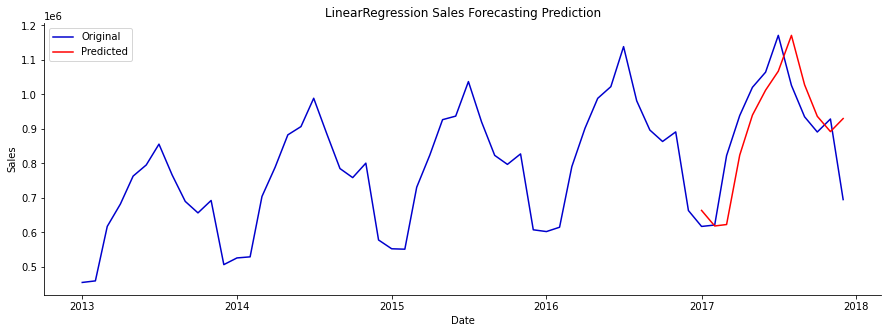

In [32]:
run_model(train, test, LinearRegression(), 'LinearRegression')

SMAPE: 5.896287357322076
RMSE: 116641.97923346466
MAE: 96129.0
R2 Score: 0.5199276055792355


C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


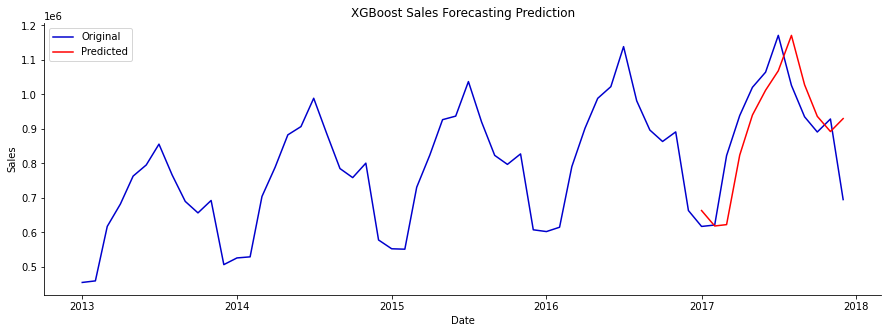

In [33]:
run_model(train, test, XGBRegressor(), 'XGBoost')

SMAPE: 5.89713195594955
RMSE: 116709.08441719522
MAE: 96173.0
R2 Score: 0.5193750667191592


C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


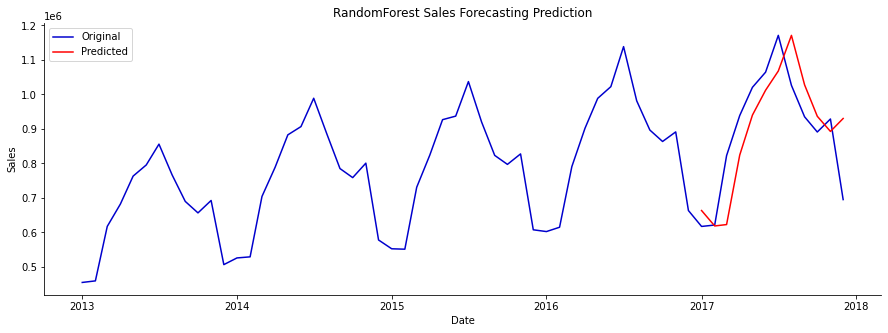

In [34]:
run_model(train, test, RandomForestRegressor(), 
          'RandomForest')

SMAPE: 5.897401137641213
RMSE: 116776.17436075449
MAE: 96208.33333333333
R2 Score: 0.5188223356645371


C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


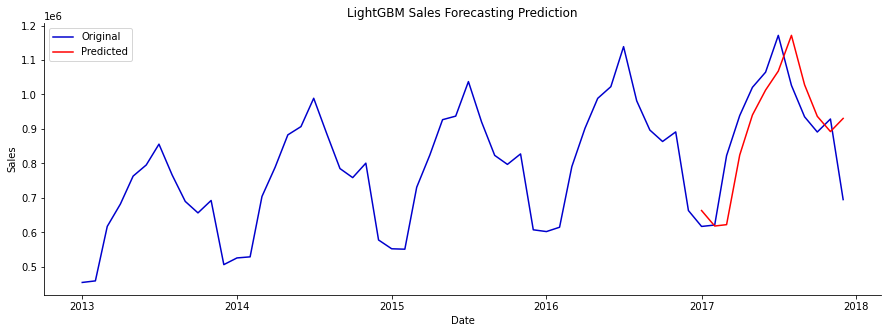

In [35]:
import lightgbm as lgb
run_model(train, test, lgb.LGBMRegressor(), 
          'LightGBM')

In [36]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


Learning rate set to 0.044931
0:	learn: 0.3468450	total: 163ms	remaining: 2m 43s
1:	learn: 0.3332943	total: 169ms	remaining: 1m 24s
2:	learn: 0.3202545	total: 174ms	remaining: 57.9s
3:	learn: 0.3082051	total: 179ms	remaining: 44.6s
4:	learn: 0.2970655	total: 183ms	remaining: 36.3s
5:	learn: 0.2852902	total: 187ms	remaining: 31s
6:	learn: 0.2750108	total: 192ms	remaining: 27.2s
7:	learn: 0.2645990	total: 196ms	remaining: 24.3s
8:	learn: 0.2547772	total: 200ms	remaining: 22.1s
9:	learn: 0.2448305	total: 206ms	remaining: 20.4s
10:	learn: 0.2353311	total: 212ms	remaining: 19s
11:	learn: 0.2268700	total: 218ms	remaining: 17.9s
12:	learn: 0.2183542	total: 224ms	remaining: 17s
13:	learn: 0.2104274	total: 230ms	remaining: 16.2s
14:	learn: 0.2027211	total: 235ms	remaining: 15.4s
15:	learn: 0.1954232	total: 240ms	remaining: 14.8s
16:	learn: 0.1886117	total: 247ms	remaining: 14.3s
17:	learn: 0.1817619	total: 252ms	remaining: 13.8s
18:	learn: 0.1753980	total: 257ms	remaining: 13.3s
19:	learn: 0.16

185:	learn: 0.0530717	total: 1.06s	remaining: 4.65s
186:	learn: 0.0530427	total: 1.07s	remaining: 4.64s
187:	learn: 0.0530086	total: 1.07s	remaining: 4.63s
188:	learn: 0.0529631	total: 1.08s	remaining: 4.62s
189:	learn: 0.0528956	total: 1.08s	remaining: 4.61s
190:	learn: 0.0528394	total: 1.08s	remaining: 4.59s
191:	learn: 0.0527888	total: 1.09s	remaining: 4.58s
192:	learn: 0.0527586	total: 1.09s	remaining: 4.58s
193:	learn: 0.0527328	total: 1.1s	remaining: 4.56s
194:	learn: 0.0526893	total: 1.1s	remaining: 4.55s
195:	learn: 0.0526248	total: 1.11s	remaining: 4.54s
196:	learn: 0.0525835	total: 1.11s	remaining: 4.54s
197:	learn: 0.0525478	total: 1.12s	remaining: 4.52s
198:	learn: 0.0525203	total: 1.12s	remaining: 4.52s
199:	learn: 0.0524657	total: 1.13s	remaining: 4.51s
200:	learn: 0.0524467	total: 1.13s	remaining: 4.5s
201:	learn: 0.0524228	total: 1.14s	remaining: 4.49s
202:	learn: 0.0523878	total: 1.14s	remaining: 4.48s
203:	learn: 0.0523660	total: 1.15s	remaining: 4.47s
204:	learn: 0.0

378:	learn: 0.0458699	total: 1.98s	remaining: 3.24s
379:	learn: 0.0458311	total: 1.98s	remaining: 3.23s
380:	learn: 0.0458254	total: 1.99s	remaining: 3.23s
381:	learn: 0.0457867	total: 1.99s	remaining: 3.22s
382:	learn: 0.0457744	total: 2s	remaining: 3.21s
383:	learn: 0.0457692	total: 2s	remaining: 3.21s
384:	learn: 0.0457292	total: 2s	remaining: 3.2s
385:	learn: 0.0457242	total: 2.01s	remaining: 3.2s
386:	learn: 0.0457174	total: 2.02s	remaining: 3.19s
387:	learn: 0.0457001	total: 2.02s	remaining: 3.19s
388:	learn: 0.0456947	total: 2.02s	remaining: 3.18s
389:	learn: 0.0456491	total: 2.03s	remaining: 3.17s
390:	learn: 0.0456073	total: 2.03s	remaining: 3.17s
391:	learn: 0.0455655	total: 2.04s	remaining: 3.16s
392:	learn: 0.0455389	total: 2.04s	remaining: 3.16s
393:	learn: 0.0455262	total: 2.05s	remaining: 3.15s
394:	learn: 0.0455082	total: 2.05s	remaining: 3.15s
395:	learn: 0.0455017	total: 2.06s	remaining: 3.14s
396:	learn: 0.0454565	total: 2.06s	remaining: 3.13s
397:	learn: 0.0453733	t

562:	learn: 0.0398233	total: 2.87s	remaining: 2.23s
563:	learn: 0.0397976	total: 2.87s	remaining: 2.22s
564:	learn: 0.0397484	total: 2.88s	remaining: 2.21s
565:	learn: 0.0397198	total: 2.88s	remaining: 2.21s
566:	learn: 0.0396992	total: 2.89s	remaining: 2.2s
567:	learn: 0.0396809	total: 2.89s	remaining: 2.2s
568:	learn: 0.0396764	total: 2.89s	remaining: 2.19s
569:	learn: 0.0396600	total: 2.9s	remaining: 2.19s
570:	learn: 0.0396388	total: 2.9s	remaining: 2.18s
571:	learn: 0.0396029	total: 2.91s	remaining: 2.18s
572:	learn: 0.0395786	total: 2.92s	remaining: 2.17s
573:	learn: 0.0395370	total: 2.92s	remaining: 2.17s
574:	learn: 0.0394947	total: 2.92s	remaining: 2.16s
575:	learn: 0.0394866	total: 2.93s	remaining: 2.16s
576:	learn: 0.0394316	total: 2.94s	remaining: 2.15s
577:	learn: 0.0394140	total: 2.94s	remaining: 2.15s
578:	learn: 0.0393955	total: 2.94s	remaining: 2.14s
579:	learn: 0.0393878	total: 2.95s	remaining: 2.14s
580:	learn: 0.0393559	total: 2.96s	remaining: 2.13s
581:	learn: 0.03

747:	learn: 0.0349167	total: 3.76s	remaining: 1.27s
748:	learn: 0.0349091	total: 3.77s	remaining: 1.26s
749:	learn: 0.0349025	total: 3.77s	remaining: 1.26s
750:	learn: 0.0348757	total: 3.77s	remaining: 1.25s
751:	learn: 0.0348604	total: 3.78s	remaining: 1.25s
752:	learn: 0.0348502	total: 3.78s	remaining: 1.24s
753:	learn: 0.0348406	total: 3.79s	remaining: 1.24s
754:	learn: 0.0348186	total: 3.79s	remaining: 1.23s
755:	learn: 0.0347927	total: 3.8s	remaining: 1.23s
756:	learn: 0.0347650	total: 3.8s	remaining: 1.22s
757:	learn: 0.0347475	total: 3.81s	remaining: 1.22s
758:	learn: 0.0347223	total: 3.81s	remaining: 1.21s
759:	learn: 0.0347111	total: 3.82s	remaining: 1.21s
760:	learn: 0.0346869	total: 3.82s	remaining: 1.2s
761:	learn: 0.0346771	total: 3.83s	remaining: 1.2s
762:	learn: 0.0346475	total: 3.83s	remaining: 1.19s
763:	learn: 0.0346267	total: 3.84s	remaining: 1.19s
764:	learn: 0.0346019	total: 3.84s	remaining: 1.18s
765:	learn: 0.0345926	total: 3.85s	remaining: 1.18s
766:	learn: 0.03

938:	learn: 0.0310016	total: 4.66s	remaining: 303ms
939:	learn: 0.0309936	total: 4.67s	remaining: 298ms
940:	learn: 0.0309661	total: 4.67s	remaining: 293ms
941:	learn: 0.0309395	total: 4.67s	remaining: 288ms
942:	learn: 0.0309236	total: 4.68s	remaining: 283ms
943:	learn: 0.0308901	total: 4.68s	remaining: 278ms
944:	learn: 0.0308704	total: 4.69s	remaining: 273ms
945:	learn: 0.0308631	total: 4.69s	remaining: 268ms
946:	learn: 0.0308329	total: 4.7s	remaining: 263ms
947:	learn: 0.0308068	total: 4.7s	remaining: 258ms
948:	learn: 0.0307891	total: 4.71s	remaining: 253ms
949:	learn: 0.0307640	total: 4.71s	remaining: 248ms
950:	learn: 0.0307449	total: 4.72s	remaining: 243ms
951:	learn: 0.0307318	total: 4.72s	remaining: 238ms
952:	learn: 0.0307211	total: 4.73s	remaining: 233ms
953:	learn: 0.0307022	total: 4.73s	remaining: 228ms
954:	learn: 0.0306840	total: 4.74s	remaining: 223ms
955:	learn: 0.0306671	total: 4.74s	remaining: 218ms
956:	learn: 0.0306423	total: 4.75s	remaining: 213ms
957:	learn: 0.

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


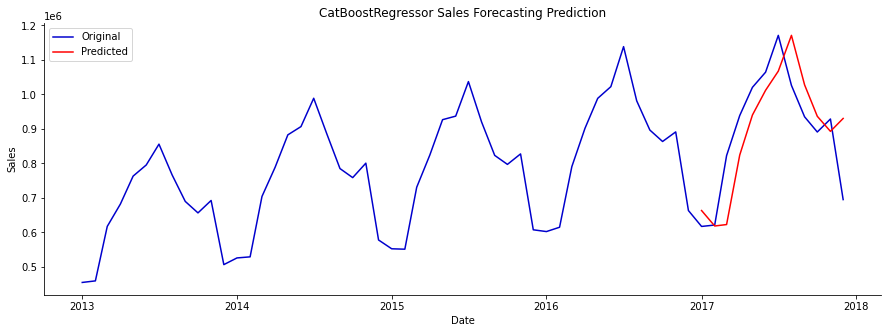

In [37]:
from catboost import CatBoostRegressor
run_model(train, test, CatBoostRegressor(), 
          'CatBoostRegressor')

# hyperparameter tuning for linear regression

In [38]:
#randomized cv
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV


In [38]:
LinearRegression().get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': False,
 'positive': False}

In [39]:
lr = RandomizedSearchCV(LinearRegression(),{
    'normalize':[True,False]
},
                       cv = 5,
                       return_train_score = False,
                       n_iter = 2)
lr.fit(X_train,y_train)
print("The best hyperparameters :")
print(lr.best_params_)
print("")
print("The best score:")
print(lr.best_score_)

The best hyperparameters :
{'normalize': True}

The best score:
0.9583873946563344


SMAPE: 5.896053887620793
RMSE: 116749.37785130448
MAE: 96285.33333333333
R2 Score: 0.5190431410219162


C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


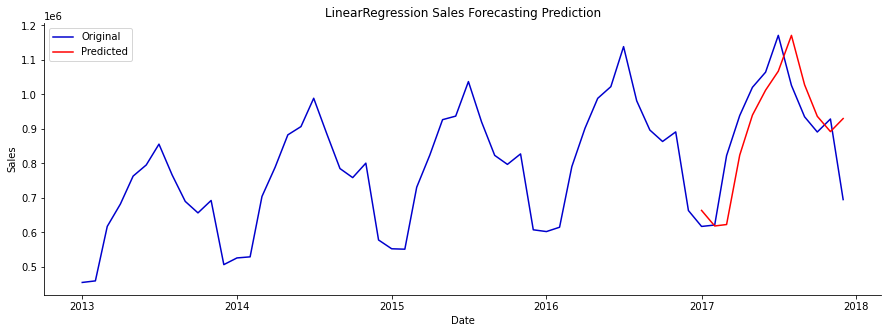

In [40]:
run_model(train, test, LinearRegression(normalize = True), 'LinearRegression')

In [41]:
pip install optuna


Note: you may need to restart the kernel to use updated packages.


In [38]:
import optuna
from sklearn.model_selection import cross_val_score

# Hyperparameter tuning for RandomForest


In [43]:
RandomForestRegressor().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [51]:
rf = RandomizedSearchCV(RandomForestRegressor(),{
'bootstrap': [True],
'max_depth': [20, 30, 40, 50, 60, 70, 80],#max number of levels in each decision tree
'max_features': ['sqrt'],# number of features in consideration at every split
'min_samples_leaf': [1, 2, 4],#min number of data points allowed in a leaf node
'min_samples_split': [2, 5, 10],#min number of data points placed in a node before the node is split
'n_estimators': [600, 800, 1000, 1200, 1400]},#unmber of trees
                       cv = 3,
                       verbose = 2,
                       n_iter = 100,
                       return_train_score = False,
                       random_state=42)
rf.fit(X_train,y_train)
print("The best hyperparameters :")
print(rf.best_params_)
print("")
print("The best score:")
print(rf.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   4.9s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   4.9s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   4.8s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   7.2s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   7.1s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   7.0s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=12

[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   4.1s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   4.1s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   4.0s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1400; total time=   8.8s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1400; total time=   9.1s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1400; total time=   9.0s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   8.0s
[CV] END bootstrap=True, max_depth=70, ma

[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1400; total time=   5.8s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1400; total time=   6.0s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1400; total time=   6.0s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1400; total time=   6.0s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1400; total time=   5.2s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1400; total time=   4.6s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1400; total time=   5.2s
[CV] END bootstrap=True, max_depth=30,

[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1400; total time=   6.2s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1400; total time=   6.0s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1400; total time=   5.7s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1200; total time=   5.1s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1200; total time=   5.4s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1200; total time=   5.1s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   3.5s
[CV] END bootstrap=True, max_depth=80,

[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   3.8s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   3.9s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   3.9s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=   5.3s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=   5.1s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=   3.9s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   2.0s
[CV] END bootstrap=True, max_depth=20, max

The best hyperparameters :
{'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': True}

The best score:
0.9685253955701499


SMAPE: 5.897569868492422
RMSE: 116718.42004620921
MAE: 96190.25
R2 Score: 0.5192981726958579


C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


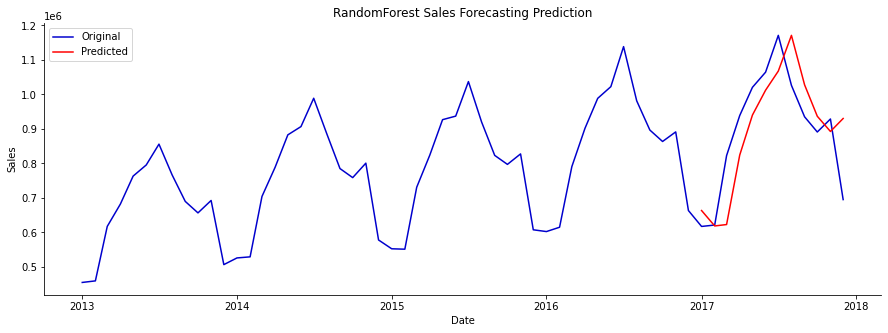

In [52]:
run_model(train, test, RandomForestRegressor(n_estimators = 600, 
                                             min_samples_split= 5, 
                                             min_samples_leaf = 2, 
                                             max_features= 'sqrt',
                                             max_depth= 70, 
                                             bootstrap = True), 
          'RandomForest')

# Hyperparameter tuning for XGBoost

In [ ]:
from xgboost import XGBRegressor

In [39]:
XGBRegressor().get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'enable_categorical': False,
 'gamma': None,
 'gpu_id': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [46]:
cv = ShuffleSplit(n_splits = 2, test_size =0.2, random_state = 42)

xg=RandomizedSearchCV(XGBRegressor(),{
    'max_depth': range(2,12),#The higher max_depth, the more levels the tree has
    'gamma':[1],#Gamma specifies the minimum loss reduction required to make a split.
    'reg_alpha':[40,80,120],#Can be used in case of very high dimensionality so that the algorithm runs faster when implemented
    'reg_lambda':[0,1,2],#it should be explored to reduce overfitting.
    'colsample_bytree':[0.5,0.6,0.7,0.8,0.9,1],#Denotes the fraction of columns to be randomly sampled for each tree.
    'min_child_weight':[0,2,4,6,8],#Used to control over-fitting. Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.
    'n_estimators': range(100,1000),
    'learning_rate':[0.01,0.02,0.03,0.04]#Makes the model more robust by shrinking the weights on each step
    },
                       cv = cv,
                       verbose = 2,
                       #random_state = 42,
                       return_train_score = False,
                       n_jobs = -1, 
                       n_iter = 500)

xg.fit(X_train,y_train)
print("The best hyperparameters :")
print(xg.best_params_)
print("")
print("The best score:")
print(xg.best_score_) #0.8520999710378194

Fitting 2 folds for each of 500 candidates, totalling 1000 fits
The best hyperparameters :
{'reg_lambda': 1, 'reg_alpha': 40, 'n_estimators': 903, 'min_child_weight': 6, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 1, 'colsample_bytree': 1}

The best score:
0.8516792206646695


SMAPE: 5.897996372915944
RMSE: 116860.03919789405
MAE: 96336.16666666667
R2 Score: 0.5181309553020998


C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


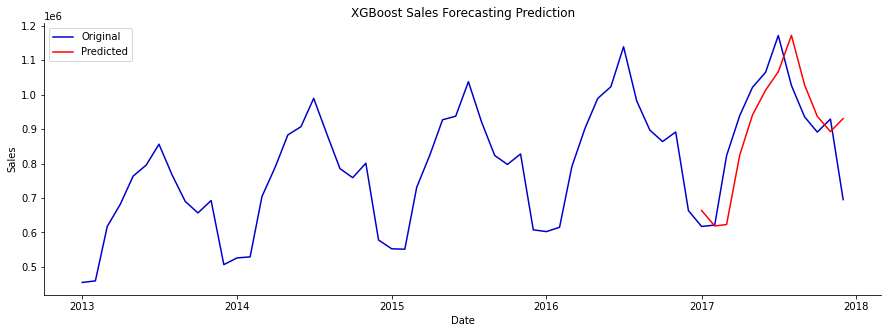

In [41]:
run_model(train, test, XGBRegressor(reg_lambda= 0, 
                                    reg_alpha= 40, 
                                    n_estimators= 900, 
                                    min_child_weight=6, 
                                    max_depth= 6, 
                                    learning_rate= 0.04, 
                                    gamma=1, 
                                    colsample_bytree=1),
          
          'XGBoost')#96129.0

# Hyparameter tuning for LGBM

In [45]:
lgb.LGBMRegressor().get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [82]:
cv = ShuffleSplit(n_splits = 2, test_size = .33, random_state = 42)

lg = RandomizedSearchCV(lgb.LGBMRegressor() ,{
       'max_depth':range(3,12),
       'num_leaves': range(50,200),#sets numbeer of nodes per tree
       'num_estimators':[200,400,600,800,1000,1400],#number of trees
       'learning_rate':[0.01,0.02,0.03,0.04],
       'max_bin':range(100,300),#controls the maximum number of bins that features will bucketed into.reduce to reduce training time
       'min_gain_to_split':range(3,15),
       'lambda_l1': [0,1,3,5],
       'lambda_l2': [0,1,3,5]#specifies L1 or L2 regularization
      },               cv = cv,
                       verbose = 2,
                       #random_state = 42,
                       return_train_score = False,
                       n_jobs = -1,
                       n_iter = 500)
lg.fit(X_train,y_train)
print("The best hyperparameters :")
print(lg.best_params_)
print("")
print("The best score:")
print(lg.best_score_)#0.9275100637564895



Fitting 2 folds for each of 500000 candidates, totalling 1000000 fits
The best hyperparameters :
{'num_leaves': 175, 'num_estimators': 1400, 'min_gain_to_split': 3, 'max_depth': 9, 'max_bin': 122, 'learning_rate': 0.04, 'lambda_l2': 0, 'lambda_l1': 0}

The best score:
0.9275100637564895


SMAPE: 5.899427971407882
RMSE: 116823.65338335099
MAE: 96307.16666666667
R2 Score: 0.5184309803273535


C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


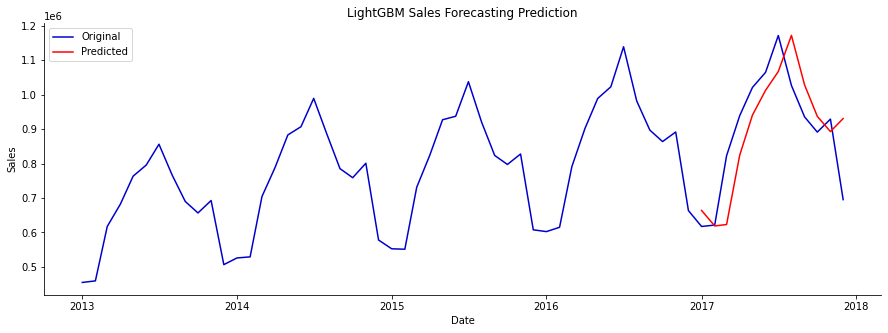

In [83]:
run_model(train, test, lgb.LGBMRegressor(num_leaves= 175, 
                                         num_estimators=1400, 
                                         min_gain_to_split=3, 
                                         max_depth= 9, 
                                         max_bin=122, 
                                         learning_rate=0.04, 
                                         lambda_l2 = 0, 
                                         lambda_l1= 0), 
          'LightGBM')#96208.33333333333

In [38]:
CatBoostRegressor().get_params()

{'loss_function': 'RMSE'}

In [39]:
cv = ShuffleSplit(n_splits = 2, test_size = .33, random_state = 42)

cb = RandomizedSearchCV(CatBoostRegressor(),{ 
        "objective": ["RMSE", "MAE","MAPE"],
        'learning_rate' :[0.001,0.005,0.01,0.015,0.02,0.025,0.03],
        "colsample_bylevel":[0.01, 0.05,0.1,0.15,0.2,0.25,0.03,0.35,0.4,0.45,0.5],
        "max_depth": [3,6,9,12,15],
        "boosting_type":["Ordered", "Plain"],
        "bootstrap_type":["Bayesian", "Bernoulli", "MVS"],
        "iterations": [30, 50, 100]
},
                       cv = cv,
                       verbose = 2,
                       #random_state = 42,
                       return_train_score = False,
                       #n_jobs = -1,
                       n_iter = 100)
cb.fit(X_train,y_train)
print("The best hyperparameters :")
print(cb.best_params_)
print("")
print("The best score:")
print(cb.best_score_)#0.9523250773422989

Fitting 2 folds for each of 100 candidates, totalling 200 fits
0:	learn: 0.2058671	total: 4.15ms	remaining: 203ms
1:	learn: 0.2057213	total: 8.32ms	remaining: 200ms
2:	learn: 0.2055852	total: 13.7ms	remaining: 214ms
3:	learn: 0.2055211	total: 16.8ms	remaining: 193ms
4:	learn: 0.2054476	total: 21.8ms	remaining: 196ms
5:	learn: 0.2052736	total: 25.5ms	remaining: 187ms
6:	learn: 0.2052219	total: 29.5ms	remaining: 181ms
7:	learn: 0.2052021	total: 32.7ms	remaining: 172ms
8:	learn: 0.2050039	total: 37.1ms	remaining: 169ms
9:	learn: 0.2049347	total: 41.6ms	remaining: 166ms
10:	learn: 0.2048704	total: 45.5ms	remaining: 161ms
11:	learn: 0.2048067	total: 49.9ms	remaining: 158ms
12:	learn: 0.2046190	total: 53.4ms	remaining: 152ms
13:	learn: 0.2045525	total: 57.9ms	remaining: 149ms
14:	learn: 0.2045143	total: 61.8ms	remaining: 144ms
15:	learn: 0.2044728	total: 66.5ms	remaining: 141ms
16:	learn: 0.2044038	total: 70.6ms	remaining: 137ms
17:	learn: 0.2042379	total: 75.1ms	remaining: 134ms
18:	learn: 

16:	learn: 0.3510907	total: 27.6ms	remaining: 53.6ms
17:	learn: 0.3510907	total: 29.1ms	remaining: 51.8ms
18:	learn: 0.3510907	total: 30.4ms	remaining: 49.5ms
19:	learn: 0.3510907	total: 31.5ms	remaining: 47.3ms
20:	learn: 0.3510907	total: 32.7ms	remaining: 45.1ms
21:	learn: 0.3501749	total: 34.2ms	remaining: 43.5ms
22:	learn: 0.3501749	total: 35.4ms	remaining: 41.6ms
23:	learn: 0.3501749	total: 36.5ms	remaining: 39.6ms
24:	learn: 0.3501749	total: 37.7ms	remaining: 37.7ms
25:	learn: 0.3501749	total: 38.8ms	remaining: 35.9ms
26:	learn: 0.3496087	total: 40.2ms	remaining: 34.2ms
27:	learn: 0.3496087	total: 41ms	remaining: 32.2ms
28:	learn: 0.3496087	total: 42ms	remaining: 30.4ms
29:	learn: 0.3496087	total: 43.1ms	remaining: 28.7ms
30:	learn: 0.3496087	total: 43.8ms	remaining: 26.9ms
31:	learn: 0.3491001	total: 44.9ms	remaining: 25.3ms
32:	learn: 0.3491001	total: 46.4ms	remaining: 23.9ms
33:	learn: 0.3491001	total: 47.4ms	remaining: 22.3ms
34:	learn: 0.3491001	total: 48.5ms	remaining: 20.8

16:	learn: 0.3206604	total: 1m 23s	remaining: 2m 42s
17:	learn: 0.3179846	total: 1m 28s	remaining: 2m 38s
18:	learn: 0.3153827	total: 1m 34s	remaining: 2m 34s
19:	learn: 0.3127386	total: 1m 40s	remaining: 2m 30s
20:	learn: 0.3101169	total: 1m 45s	remaining: 2m 25s
21:	learn: 0.3074807	total: 1m 47s	remaining: 2m 17s
22:	learn: 0.3049370	total: 1m 53s	remaining: 2m 12s
23:	learn: 0.3023785	total: 1m 58s	remaining: 2m 8s
24:	learn: 0.2998596	total: 2m 4s	remaining: 2m 4s
25:	learn: 0.2974468	total: 2m 10s	remaining: 2m
26:	learn: 0.2949090	total: 2m 16s	remaining: 1m 55s
27:	learn: 0.2924690	total: 2m 20s	remaining: 1m 50s
28:	learn: 0.2900657	total: 2m 26s	remaining: 1m 45s
29:	learn: 0.2876836	total: 2m 31s	remaining: 1m 41s
30:	learn: 0.2853262	total: 2m 36s	remaining: 1m 36s
31:	learn: 0.2829746	total: 2m 42s	remaining: 1m 31s
32:	learn: 0.2806736	total: 2m 48s	remaining: 1m 26s
33:	learn: 0.2783712	total: 2m 53s	remaining: 1m 21s
34:	learn: 0.2760314	total: 2m 58s	remaining: 1m 16s


70:	learn: 0.1347611	total: 27.5s	remaining: 11.2s
71:	learn: 0.1329101	total: 27.5s	remaining: 10.7s
72:	learn: 0.1312664	total: 27.5s	remaining: 10.2s
73:	learn: 0.1292481	total: 28.6s	remaining: 10.1s
74:	learn: 0.1272999	total: 32.9s	remaining: 11s
75:	learn: 0.1253077	total: 37.5s	remaining: 11.8s
76:	learn: 0.1253077	total: 37.5s	remaining: 11.2s
77:	learn: 0.1253077	total: 37.5s	remaining: 10.6s
78:	learn: 0.1238026	total: 37.5s	remaining: 9.97s
79:	learn: 0.1222226	total: 37.5s	remaining: 9.38s
80:	learn: 0.1205228	total: 37.5s	remaining: 8.81s
81:	learn: 0.1200635	total: 37.5s	remaining: 8.24s
82:	learn: 0.1186050	total: 37.5s	remaining: 7.69s
83:	learn: 0.1173941	total: 37.6s	remaining: 7.15s
84:	learn: 0.1158443	total: 37.6s	remaining: 6.63s
85:	learn: 0.1147976	total: 37.6s	remaining: 6.11s
86:	learn: 0.1147976	total: 37.6s	remaining: 5.61s
87:	learn: 0.1132016	total: 37.6s	remaining: 5.13s
88:	learn: 0.1119772	total: 37.6s	remaining: 4.65s
89:	learn: 0.1105296	total: 38.2s

26:	learn: 0.1460331	total: 14.4s	remaining: 1.6s
27:	learn: 0.1444352	total: 14.4s	remaining: 1.03s
28:	learn: 0.1425362	total: 14.9s	remaining: 514ms
29:	learn: 0.1410129	total: 15.4s	remaining: 0us
[CV] END boosting_type=Ordered, bootstrap_type=MVS, colsample_bylevel=0.35, iterations=30, learning_rate=0.015, max_depth=12, objective=MAPE; total time=  15.3s
0:	learn: 0.2078448	total: 564ms	remaining: 16.4s
1:	learn: 0.2054862	total: 1.12s	remaining: 15.6s
2:	learn: 0.2046795	total: 1.12s	remaining: 10.1s
3:	learn: 0.2021278	total: 1.68s	remaining: 10.9s
4:	learn: 0.1994976	total: 2.27s	remaining: 11.4s
5:	learn: 0.1967828	total: 2.84s	remaining: 11.3s
6:	learn: 0.1940923	total: 3.44s	remaining: 11.3s
7:	learn: 0.1914945	total: 4.03s	remaining: 11.1s
8:	learn: 0.1886509	total: 4.63s	remaining: 10.8s
9:	learn: 0.1860748	total: 5.23s	remaining: 10.5s
10:	learn: 0.1837996	total: 5.84s	remaining: 10.1s
11:	learn: 0.1812660	total: 6.44s	remaining: 9.66s
12:	learn: 0.1790333	total: 7.06s	re

19:	learn: 0.2264442	total: 13.6s	remaining: 54.3s
20:	learn: 0.2213979	total: 14.2s	remaining: 53.4s
21:	learn: 0.2158852	total: 14.8s	remaining: 52.6s
22:	learn: 0.2107224	total: 15.5s	remaining: 51.8s
23:	learn: 0.2056083	total: 16.3s	remaining: 51.7s
24:	learn: 0.2007670	total: 17s	remaining: 50.9s
25:	learn: 0.1958221	total: 17.6s	remaining: 50.1s
26:	learn: 0.1912352	total: 18.3s	remaining: 49.4s
27:	learn: 0.1866527	total: 18.9s	remaining: 48.6s
28:	learn: 0.1822716	total: 18.9s	remaining: 46.3s
29:	learn: 0.1778056	total: 19.5s	remaining: 45.6s
30:	learn: 0.1735531	total: 20.2s	remaining: 45s
31:	learn: 0.1696421	total: 20.9s	remaining: 44.4s
32:	learn: 0.1656178	total: 21.5s	remaining: 43.7s
33:	learn: 0.1617512	total: 22.2s	remaining: 43.2s
34:	learn: 0.1580215	total: 22.9s	remaining: 42.5s
35:	learn: 0.1544516	total: 23.6s	remaining: 41.9s
36:	learn: 0.1509442	total: 24.2s	remaining: 41.3s
37:	learn: 0.1475351	total: 25s	remaining: 40.8s
38:	learn: 0.1442530	total: 25.6s	rem

28:	learn: 0.2140783	total: 682ms	remaining: 494ms
29:	learn: 0.2091827	total: 685ms	remaining: 456ms
30:	learn: 0.2047627	total: 692ms	remaining: 424ms
31:	learn: 0.1999592	total: 790ms	remaining: 444ms
32:	learn: 0.1957461	total: 870ms	remaining: 448ms
33:	learn: 0.1911862	total: 872ms	remaining: 410ms
34:	learn: 0.1871579	total: 968ms	remaining: 415ms
35:	learn: 0.1856655	total: 969ms	remaining: 377ms
36:	learn: 0.1815961	total: 1.06s	remaining: 374ms
37:	learn: 0.1776588	total: 1.16s	remaining: 367ms
38:	learn: 0.1739012	total: 1.17s	remaining: 329ms
39:	learn: 0.1700741	total: 1.27s	remaining: 317ms
40:	learn: 0.1662156	total: 1.36s	remaining: 298ms
41:	learn: 0.1662150	total: 1.36s	remaining: 259ms
42:	learn: 0.1627912	total: 1.45s	remaining: 236ms
43:	learn: 0.1596764	total: 1.55s	remaining: 211ms
44:	learn: 0.1562357	total: 1.65s	remaining: 183ms
45:	learn: 0.1531686	total: 1.74s	remaining: 152ms
46:	learn: 0.1501631	total: 1.75s	remaining: 111ms
47:	learn: 0.1470006	total: 1.8

40:	learn: 0.1759695	total: 183ms	remaining: 40.2ms
41:	learn: 0.1753083	total: 188ms	remaining: 35.9ms
42:	learn: 0.1745905	total: 192ms	remaining: 31.3ms
43:	learn: 0.1739715	total: 203ms	remaining: 27.6ms
44:	learn: 0.1732997	total: 208ms	remaining: 23.1ms
45:	learn: 0.1725764	total: 211ms	remaining: 18.3ms
46:	learn: 0.1717047	total: 216ms	remaining: 13.8ms
47:	learn: 0.1709696	total: 221ms	remaining: 9.19ms
48:	learn: 0.1704618	total: 224ms	remaining: 4.57ms
49:	learn: 0.1701986	total: 229ms	remaining: 0us
[CV] END boosting_type=Plain, bootstrap_type=Bernoulli, colsample_bylevel=0.5, iterations=50, learning_rate=0.005, max_depth=6, objective=MAPE; total time=   0.2s
0:	learn: 0.2098103	total: 21.7ms	remaining: 1.06s
1:	learn: 0.2094326	total: 26.6ms	remaining: 638ms
2:	learn: 0.2086365	total: 30.4ms	remaining: 476ms
3:	learn: 0.2078930	total: 34.6ms	remaining: 398ms
4:	learn: 0.2069435	total: 38.6ms	remaining: 347ms
5:	learn: 0.2066000	total: 43ms	remaining: 316ms
6:	learn: 0.2060

0:	learn: 0.2107132	total: 1.45ms	remaining: 71.2ms
1:	learn: 0.2107132	total: 3.21ms	remaining: 77ms
2:	learn: 0.2107132	total: 4.74ms	remaining: 74.3ms
3:	learn: 0.2107132	total: 6.23ms	remaining: 71.6ms
4:	learn: 0.2107132	total: 7.87ms	remaining: 70.9ms
5:	learn: 0.2107132	total: 9.6ms	remaining: 70.4ms
6:	learn: 0.2107132	total: 10.4ms	remaining: 64ms
7:	learn: 0.2101183	total: 11.4ms	remaining: 59.6ms
8:	learn: 0.2101182	total: 12.3ms	remaining: 55.9ms
9:	learn: 0.2100354	total: 14.2ms	remaining: 56.6ms
10:	learn: 0.2099810	total: 16.1ms	remaining: 57ms
11:	learn: 0.2099810	total: 17.5ms	remaining: 55.4ms
12:	learn: 0.2099810	total: 18.9ms	remaining: 53.8ms
13:	learn: 0.2099810	total: 20.5ms	remaining: 52.7ms
14:	learn: 0.2099810	total: 21.9ms	remaining: 51.2ms
15:	learn: 0.2099810	total: 23.3ms	remaining: 49.6ms
16:	learn: 0.2099434	total: 25.2ms	remaining: 49ms
17:	learn: 0.2097852	total: 27ms	remaining: 48ms
18:	learn: 0.2097852	total: 28.2ms	remaining: 45.9ms
19:	learn: 0.209

1:	learn: 0.3654882	total: 2.58ms	remaining: 36.1ms
2:	learn: 0.3604733	total: 4.16ms	remaining: 37.4ms
3:	learn: 0.3542214	total: 5.28ms	remaining: 34.3ms
4:	learn: 0.3485574	total: 6.62ms	remaining: 33.1ms
5:	learn: 0.3471188	total: 7.88ms	remaining: 31.5ms
6:	learn: 0.3424573	total: 9.02ms	remaining: 29.6ms
7:	learn: 0.3424573	total: 9.67ms	remaining: 26.6ms
8:	learn: 0.3424573	total: 10.3ms	remaining: 24.1ms
9:	learn: 0.3372046	total: 11.8ms	remaining: 23.7ms
10:	learn: 0.3316086	total: 13.4ms	remaining: 23.1ms
11:	learn: 0.3290920	total: 15ms	remaining: 22.5ms
12:	learn: 0.3248159	total: 16ms	remaining: 20.9ms
13:	learn: 0.3203678	total: 17.6ms	remaining: 20.1ms
14:	learn: 0.3157470	total: 18.9ms	remaining: 18.9ms
15:	learn: 0.3102766	total: 20.5ms	remaining: 17.9ms
16:	learn: 0.3063497	total: 21.8ms	remaining: 16.6ms
17:	learn: 0.3040871	total: 23.4ms	remaining: 15.6ms
18:	learn: 0.2990322	total: 24.9ms	remaining: 14.4ms
19:	learn: 0.2987665	total: 25.8ms	remaining: 12.9ms
20:	le

57:	learn: 0.2984980	total: 113ms	remaining: 81.6ms
58:	learn: 0.2984980	total: 114ms	remaining: 79.3ms
59:	learn: 0.2984980	total: 115ms	remaining: 77ms
60:	learn: 0.2984980	total: 117ms	remaining: 74.6ms
61:	learn: 0.2984980	total: 118ms	remaining: 72.3ms
62:	learn: 0.2924179	total: 120ms	remaining: 70.3ms
63:	learn: 0.2924179	total: 121ms	remaining: 68ms
64:	learn: 0.2898911	total: 123ms	remaining: 66ms
65:	learn: 0.2874005	total: 125ms	remaining: 64.2ms
66:	learn: 0.2805969	total: 161ms	remaining: 79.5ms
67:	learn: 0.2795452	total: 163ms	remaining: 76.9ms
68:	learn: 0.2739631	total: 166ms	remaining: 74.8ms
69:	learn: 0.2739631	total: 168ms	remaining: 71.9ms
70:	learn: 0.2739631	total: 169ms	remaining: 69.1ms
71:	learn: 0.2734879	total: 171ms	remaining: 66.5ms
72:	learn: 0.2733924	total: 173ms	remaining: 63.9ms
73:	learn: 0.2686152	total: 175ms	remaining: 61.4ms
74:	learn: 0.2686152	total: 176ms	remaining: 58.8ms
75:	learn: 0.2676977	total: 179ms	remaining: 56.4ms
76:	learn: 0.26769

14:	learn: 0.3729061	total: 206ms	remaining: 206ms
15:	learn: 0.3725715	total: 223ms	remaining: 195ms
16:	learn: 0.3722388	total: 236ms	remaining: 180ms
17:	learn: 0.3719160	total: 247ms	remaining: 165ms
18:	learn: 0.3716647	total: 251ms	remaining: 145ms
19:	learn: 0.3713741	total: 263ms	remaining: 131ms
20:	learn: 0.3710640	total: 279ms	remaining: 119ms
21:	learn: 0.3707463	total: 292ms	remaining: 106ms
22:	learn: 0.3704326	total: 309ms	remaining: 94ms
23:	learn: 0.3701177	total: 321ms	remaining: 80.3ms
24:	learn: 0.3697998	total: 334ms	remaining: 66.7ms
25:	learn: 0.3694879	total: 342ms	remaining: 52.6ms
26:	learn: 0.3691559	total: 356ms	remaining: 39.6ms
27:	learn: 0.3688376	total: 367ms	remaining: 26.2ms
28:	learn: 0.3685212	total: 383ms	remaining: 13.2ms
29:	learn: 0.3682137	total: 392ms	remaining: 0us
[CV] END boosting_type=Ordered, bootstrap_type=Bayesian, colsample_bylevel=0.25, iterations=30, learning_rate=0.001, max_depth=6, objective=RMSE; total time=   0.4s
0:	learn: 0.2020

39:	learn: 0.1730954	total: 788ms	remaining: 197ms
40:	learn: 0.1723665	total: 819ms	remaining: 180ms
41:	learn: 0.1716470	total: 837ms	remaining: 159ms
42:	learn: 0.1709113	total: 857ms	remaining: 140ms
43:	learn: 0.1703973	total: 876ms	remaining: 119ms
44:	learn: 0.1698300	total: 894ms	remaining: 99.3ms
45:	learn: 0.1690800	total: 914ms	remaining: 79.5ms
46:	learn: 0.1683777	total: 933ms	remaining: 59.6ms
47:	learn: 0.1676259	total: 951ms	remaining: 39.6ms
48:	learn: 0.1669163	total: 969ms	remaining: 19.8ms
49:	learn: 0.1661613	total: 987ms	remaining: 0us
[CV] END boosting_type=Plain, bootstrap_type=MVS, colsample_bylevel=0.5, iterations=50, learning_rate=0.005, max_depth=9, objective=MAE; total time=   1.0s
0:	learn: 0.2097696	total: 21.5ms	remaining: 1.05s
1:	learn: 0.2088301	total: 41.2ms	remaining: 989ms
2:	learn: 0.2079193	total: 59.5ms	remaining: 931ms
3:	learn: 0.2070190	total: 78ms	remaining: 896ms
4:	learn: 0.2061515	total: 95.1ms	remaining: 856ms
5:	learn: 0.2052048	total: 

29:	learn: 0.2020047	total: 33.7s	remaining: 1m 18s
30:	learn: 0.2018250	total: 37.9s	remaining: 1m 24s
31:	learn: 0.2018250	total: 37.9s	remaining: 1m 20s
32:	learn: 0.2016426	total: 42.2s	remaining: 1m 25s
33:	learn: 0.2014438	total: 42.2s	remaining: 1m 21s
34:	learn: 0.2013971	total: 42.2s	remaining: 1m 18s
35:	learn: 0.2012083	total: 47s	remaining: 1m 23s
36:	learn: 0.2010224	total: 47.3s	remaining: 1m 20s
37:	learn: 0.2008209	total: 47.3s	remaining: 1m 17s
38:	learn: 0.2006381	total: 47.6s	remaining: 1m 14s
39:	learn: 0.2004494	total: 47.6s	remaining: 1m 11s
40:	learn: 0.2002799	total: 48.2s	remaining: 1m 9s
41:	learn: 0.2002799	total: 48.2s	remaining: 1m 6s
42:	learn: 0.2001654	total: 48.2s	remaining: 1m 3s
43:	learn: 0.2001639	total: 48.2s	remaining: 1m 1s
44:	learn: 0.2001639	total: 48.2s	remaining: 58.9s
45:	learn: 0.1999848	total: 52.5s	remaining: 1m 1s
46:	learn: 0.1999473	total: 52.5s	remaining: 59.2s
47:	learn: 0.1997978	total: 57s	remaining: 1m 1s
48:	learn: 0.1996552	tot

88:	learn: 0.1982004	total: 2m 32s	remaining: 18.8s
89:	learn: 0.1980135	total: 2m 36s	remaining: 17.4s
90:	learn: 0.1980120	total: 2m 36s	remaining: 15.5s
91:	learn: 0.1978293	total: 2m 36s	remaining: 13.6s
92:	learn: 0.1978292	total: 2m 36s	remaining: 11.8s
93:	learn: 0.1978291	total: 2m 36s	remaining: 10s
94:	learn: 0.1978165	total: 2m 36s	remaining: 8.25s
95:	learn: 0.1976356	total: 2m 36s	remaining: 6.53s
96:	learn: 0.1974693	total: 2m 36s	remaining: 4.85s
97:	learn: 0.1972965	total: 2m 37s	remaining: 3.22s
98:	learn: 0.1971189	total: 2m 37s	remaining: 1.59s
99:	learn: 0.1971116	total: 2m 37s	remaining: 0us
[CV] END boosting_type=Ordered, bootstrap_type=Bernoulli, colsample_bylevel=0.2, iterations=100, learning_rate=0.001, max_depth=15, objective=MAE; total time= 2.6min
0:	learn: 0.2050197	total: 1.81ms	remaining: 88.9ms
1:	learn: 0.2044235	total: 3.79ms	remaining: 90.9ms
2:	learn: 0.2042056	total: 5.78ms	remaining: 90.6ms
3:	learn: 0.2039111	total: 7.49ms	remaining: 86.1ms
4:	lea

1:	learn: 0.2019236	total: 3.67ms	remaining: 180ms
2:	learn: 0.1999552	total: 5.74ms	remaining: 185ms
3:	learn: 0.1987717	total: 7.41ms	remaining: 178ms
4:	learn: 0.1953853	total: 9.26ms	remaining: 176ms
5:	learn: 0.1938171	total: 10.8ms	remaining: 169ms
6:	learn: 0.1912311	total: 12.6ms	remaining: 167ms
7:	learn: 0.1889765	total: 14.1ms	remaining: 162ms
8:	learn: 0.1862863	total: 15.9ms	remaining: 161ms
9:	learn: 0.1856128	total: 17.5ms	remaining: 158ms
10:	learn: 0.1844915	total: 19.3ms	remaining: 156ms
11:	learn: 0.1820077	total: 20.8ms	remaining: 153ms
12:	learn: 0.1796116	total: 22.7ms	remaining: 152ms
13:	learn: 0.1792211	total: 24.2ms	remaining: 149ms
14:	learn: 0.1779056	total: 26ms	remaining: 147ms
15:	learn: 0.1744253	total: 27.5ms	remaining: 145ms
16:	learn: 0.1710137	total: 29.4ms	remaining: 143ms
17:	learn: 0.1679137	total: 30.9ms	remaining: 141ms
18:	learn: 0.1646852	total: 32.6ms	remaining: 139ms
19:	learn: 0.1621648	total: 34.3ms	remaining: 137ms
20:	learn: 0.1605275	to

63:	learn: 0.0936016	total: 113ms	remaining: 63.5ms
64:	learn: 0.0925398	total: 115ms	remaining: 61.9ms
65:	learn: 0.0912587	total: 117ms	remaining: 60ms
66:	learn: 0.0902824	total: 119ms	remaining: 58.4ms
67:	learn: 0.0890849	total: 121ms	remaining: 56.8ms
68:	learn: 0.0879003	total: 122ms	remaining: 55ms
69:	learn: 0.0867347	total: 124ms	remaining: 53.2ms
70:	learn: 0.0857891	total: 126ms	remaining: 51.4ms
71:	learn: 0.0846665	total: 128ms	remaining: 49.8ms
72:	learn: 0.0836769	total: 130ms	remaining: 47.9ms
73:	learn: 0.0825871	total: 131ms	remaining: 46.1ms
74:	learn: 0.0815260	total: 133ms	remaining: 44.4ms
75:	learn: 0.0805116	total: 135ms	remaining: 42.7ms
76:	learn: 0.0794529	total: 137ms	remaining: 40.9ms
77:	learn: 0.0785034	total: 138ms	remaining: 39ms
78:	learn: 0.0777293	total: 140ms	remaining: 37.2ms
79:	learn: 0.0767832	total: 142ms	remaining: 35.6ms
80:	learn: 0.0759110	total: 144ms	remaining: 33.7ms
81:	learn: 0.0749320	total: 145ms	remaining: 31.9ms
82:	learn: 0.07404

21:	learn: 0.1758417	total: 286ms	remaining: 1.01s
22:	learn: 0.1743987	total: 288ms	remaining: 964ms
23:	learn: 0.1730561	total: 292ms	remaining: 923ms
24:	learn: 0.1716453	total: 300ms	remaining: 899ms
25:	learn: 0.1701445	total: 315ms	remaining: 896ms
26:	learn: 0.1687763	total: 333ms	remaining: 900ms
27:	learn: 0.1673655	total: 338ms	remaining: 868ms
28:	learn: 0.1660105	total: 352ms	remaining: 861ms
29:	learn: 0.1645706	total: 368ms	remaining: 858ms
30:	learn: 0.1630745	total: 383ms	remaining: 853ms
31:	learn: 0.1616475	total: 400ms	remaining: 850ms
32:	learn: 0.1602355	total: 417ms	remaining: 846ms
33:	learn: 0.1602337	total: 419ms	remaining: 813ms
34:	learn: 0.1589986	total: 433ms	remaining: 804ms
35:	learn: 0.1575671	total: 450ms	remaining: 799ms
36:	learn: 0.1566124	total: 454ms	remaining: 773ms
37:	learn: 0.1561669	total: 455ms	remaining: 743ms
38:	learn: 0.1547879	total: 469ms	remaining: 734ms
39:	learn: 0.1534646	total: 485ms	remaining: 728ms
40:	learn: 0.1523073	total: 501

2:	learn: 0.3476466	total: 61.5ms	remaining: 1.99s
3:	learn: 0.3406178	total: 80.4ms	remaining: 1.93s
4:	learn: 0.3338809	total: 99.7ms	remaining: 1.89s
5:	learn: 0.3271149	total: 117ms	remaining: 1.84s
6:	learn: 0.3200403	total: 136ms	remaining: 1.81s
7:	learn: 0.3135982	total: 155ms	remaining: 1.78s
8:	learn: 0.3070560	total: 172ms	remaining: 1.74s
9:	learn: 0.3012545	total: 189ms	remaining: 1.71s
10:	learn: 0.2949617	total: 208ms	remaining: 1.68s
11:	learn: 0.2888967	total: 226ms	remaining: 1.65s
12:	learn: 0.2835811	total: 244ms	remaining: 1.63s
13:	learn: 0.2782120	total: 262ms	remaining: 1.61s
14:	learn: 0.2723110	total: 281ms	remaining: 1.59s
15:	learn: 0.2671617	total: 299ms	remaining: 1.57s
16:	learn: 0.2616526	total: 318ms	remaining: 1.55s
17:	learn: 0.2564678	total: 338ms	remaining: 1.54s
18:	learn: 0.2514407	total: 358ms	remaining: 1.52s
19:	learn: 0.2462730	total: 376ms	remaining: 1.5s
20:	learn: 0.2418527	total: 395ms	remaining: 1.49s
21:	learn: 0.2370277	total: 413ms	rem

63:	learn: 0.1110041	total: 1.3s	remaining: 730ms
64:	learn: 0.1091316	total: 1.32s	remaining: 710ms
65:	learn: 0.1075493	total: 1.34s	remaining: 690ms
66:	learn: 0.1059130	total: 1.36s	remaining: 669ms
67:	learn: 0.1045610	total: 1.38s	remaining: 648ms
68:	learn: 0.1029723	total: 1.4s	remaining: 627ms
69:	learn: 0.1015429	total: 1.41s	remaining: 606ms
70:	learn: 0.1000020	total: 1.44s	remaining: 587ms
71:	learn: 0.0986554	total: 1.46s	remaining: 566ms
72:	learn: 0.0973664	total: 1.47s	remaining: 546ms
73:	learn: 0.0959872	total: 1.49s	remaining: 525ms
74:	learn: 0.0948308	total: 1.52s	remaining: 506ms
75:	learn: 0.0935402	total: 1.54s	remaining: 487ms
76:	learn: 0.0922687	total: 1.56s	remaining: 466ms
77:	learn: 0.0910897	total: 1.58s	remaining: 446ms
78:	learn: 0.0898191	total: 1.6s	remaining: 426ms
79:	learn: 0.0886302	total: 1.62s	remaining: 406ms
80:	learn: 0.0875664	total: 1.64s	remaining: 385ms
81:	learn: 0.0864694	total: 1.66s	remaining: 365ms
82:	learn: 0.0853988	total: 1.68s	

7:	learn: 0.2045181	total: 39.4ms	remaining: 108ms
8:	learn: 0.2037834	total: 44.6ms	remaining: 104ms
9:	learn: 0.2029350	total: 51.2ms	remaining: 102ms
10:	learn: 0.2020674	total: 56.6ms	remaining: 97.8ms
11:	learn: 0.2012343	total: 58.7ms	remaining: 88.1ms
12:	learn: 0.2005614	total: 63.4ms	remaining: 82.9ms
13:	learn: 0.1998757	total: 68.8ms	remaining: 78.6ms
14:	learn: 0.1994066	total: 73.6ms	remaining: 73.6ms
15:	learn: 0.1985443	total: 79.9ms	remaining: 69.9ms
16:	learn: 0.1976935	total: 85ms	remaining: 65ms
17:	learn: 0.1966588	total: 89.9ms	remaining: 59.9ms
18:	learn: 0.1961628	total: 96ms	remaining: 55.6ms
19:	learn: 0.1955774	total: 102ms	remaining: 50.8ms
20:	learn: 0.1953331	total: 105ms	remaining: 45.1ms
21:	learn: 0.1942354	total: 110ms	remaining: 40.1ms
22:	learn: 0.1934090	total: 115ms	remaining: 35.1ms
23:	learn: 0.1925767	total: 119ms	remaining: 29.9ms
24:	learn: 0.1915742	total: 124ms	remaining: 24.9ms
25:	learn: 0.1907733	total: 129ms	remaining: 19.9ms
26:	learn: 0

14:	learn: 0.2044512	total: 24.5ms	remaining: 57.1ms
15:	learn: 0.2005484	total: 27.5ms	remaining: 58.5ms
16:	learn: 0.2005451	total: 28.5ms	remaining: 55.2ms
17:	learn: 0.1967097	total: 31.2ms	remaining: 55.4ms
18:	learn: 0.1967057	total: 33.1ms	remaining: 54.1ms
19:	learn: 0.1961934	total: 35.7ms	remaining: 53.5ms
20:	learn: 0.1957761	total: 37.9ms	remaining: 52.3ms
21:	learn: 0.1957731	total: 39.4ms	remaining: 50.2ms
22:	learn: 0.1952130	total: 41.2ms	remaining: 48.4ms
23:	learn: 0.1952095	total: 42.6ms	remaining: 46.2ms
24:	learn: 0.1945683	total: 44.2ms	remaining: 44.2ms
25:	learn: 0.1945644	total: 46.2ms	remaining: 42.6ms
26:	learn: 0.1945216	total: 47.8ms	remaining: 40.8ms
27:	learn: 0.1910372	total: 51.3ms	remaining: 40.3ms
28:	learn: 0.1910347	total: 53ms	remaining: 38.4ms
29:	learn: 0.1867896	total: 55.2ms	remaining: 36.8ms
30:	learn: 0.1867815	total: 56.6ms	remaining: 34.7ms
31:	learn: 0.1864145	total: 59ms	remaining: 33.2ms
32:	learn: 0.1860706	total: 60.5ms	remaining: 31.2

15:	learn: 0.1443646	total: 1.71s	remaining: 1.5s
16:	learn: 0.1413135	total: 1.82s	remaining: 1.39s
17:	learn: 0.1383572	total: 1.93s	remaining: 1.28s
18:	learn: 0.1355023	total: 2.04s	remaining: 1.18s
19:	learn: 0.1325074	total: 2.15s	remaining: 1.07s
20:	learn: 0.1295902	total: 2.25s	remaining: 967ms
21:	learn: 0.1268220	total: 2.37s	remaining: 863ms
22:	learn: 0.1240436	total: 2.48s	remaining: 755ms
23:	learn: 0.1213735	total: 2.59s	remaining: 648ms
24:	learn: 0.1186980	total: 2.7s	remaining: 540ms
25:	learn: 0.1161494	total: 2.81s	remaining: 433ms
26:	learn: 0.1138922	total: 2.92s	remaining: 325ms
27:	learn: 0.1114528	total: 3.04s	remaining: 217ms
28:	learn: 0.1091359	total: 3.15s	remaining: 109ms
29:	learn: 0.1068252	total: 3.27s	remaining: 0us
[CV] END boosting_type=Plain, bootstrap_type=Bayesian, colsample_bylevel=0.45, iterations=30, learning_rate=0.025, max_depth=12, objective=MAE; total time=   3.2s
0:	learn: 0.2059077	total: 111ms	remaining: 3.23s
1:	learn: 0.2010163	total:

26:	learn: 0.2083526	total: 49.1ms	remaining: 133ms
27:	learn: 0.2083522	total: 50.7ms	remaining: 130ms
28:	learn: 0.2083519	total: 52.6ms	remaining: 129ms
29:	learn: 0.2083515	total: 54.3ms	remaining: 127ms
30:	learn: 0.2083512	total: 55.7ms	remaining: 124ms
31:	learn: 0.2083508	total: 57.6ms	remaining: 122ms
32:	learn: 0.2083505	total: 59.4ms	remaining: 121ms
33:	learn: 0.2083502	total: 60.8ms	remaining: 118ms
34:	learn: 0.2067841	total: 62.6ms	remaining: 116ms
35:	learn: 0.2067752	total: 64.2ms	remaining: 114ms
36:	learn: 0.2067666	total: 65.6ms	remaining: 112ms
37:	learn: 0.2067586	total: 67ms	remaining: 109ms
38:	learn: 0.2067515	total: 68.5ms	remaining: 107ms
39:	learn: 0.2067453	total: 70.4ms	remaining: 106ms
40:	learn: 0.2067394	total: 71.9ms	remaining: 103ms
41:	learn: 0.2067337	total: 73.3ms	remaining: 101ms
42:	learn: 0.2067283	total: 75.2ms	remaining: 99.6ms
43:	learn: 0.2063209	total: 77.1ms	remaining: 98.2ms
44:	learn: 0.2063158	total: 78.7ms	remaining: 96.2ms
45:	learn: 

1:	learn: 0.2104184	total: 4.11ms	remaining: 98.7ms
2:	learn: 0.2104184	total: 6.13ms	remaining: 96.1ms
3:	learn: 0.2104183	total: 7.63ms	remaining: 87.8ms
4:	learn: 0.2098795	total: 9.94ms	remaining: 89.5ms
5:	learn: 0.2098795	total: 11.4ms	remaining: 83.6ms
6:	learn: 0.2098794	total: 13ms	remaining: 80.2ms
7:	learn: 0.2097175	total: 14.7ms	remaining: 77.4ms
8:	learn: 0.2097175	total: 16.4ms	remaining: 74.5ms
9:	learn: 0.2097174	total: 17.8ms	remaining: 71.2ms
10:	learn: 0.2091576	total: 19.5ms	remaining: 69.1ms
11:	learn: 0.2085935	total: 21.7ms	remaining: 68.6ms
12:	learn: 0.2085935	total: 23.1ms	remaining: 65.8ms
13:	learn: 0.2085934	total: 24.7ms	remaining: 63.5ms
14:	learn: 0.2084681	total: 26.8ms	remaining: 62.6ms
15:	learn: 0.2069491	total: 29.7ms	remaining: 63.2ms
16:	learn: 0.2069489	total: 31.3ms	remaining: 60.7ms
17:	learn: 0.2055804	total: 34.1ms	remaining: 60.6ms
18:	learn: 0.2055801	total: 35ms	remaining: 57.1ms
19:	learn: 0.2053731	total: 37.6ms	remaining: 56.4ms
20:	le

58:	learn: 0.1723783	total: 109ms	remaining: 75.6ms
59:	learn: 0.1723731	total: 110ms	remaining: 73.1ms
60:	learn: 0.1720517	total: 111ms	remaining: 70.9ms
61:	learn: 0.1704361	total: 112ms	remaining: 68.7ms
62:	learn: 0.1702023	total: 113ms	remaining: 66.3ms
63:	learn: 0.1679096	total: 126ms	remaining: 70.8ms
64:	learn: 0.1679054	total: 127ms	remaining: 68.7ms
65:	learn: 0.1677389	total: 129ms	remaining: 66.3ms
66:	learn: 0.1655914	total: 132ms	remaining: 65ms
67:	learn: 0.1655868	total: 133ms	remaining: 62.4ms
68:	learn: 0.1653572	total: 134ms	remaining: 60.1ms
69:	learn: 0.1629503	total: 148ms	remaining: 63.5ms
70:	learn: 0.1623022	total: 152ms	remaining: 62ms
71:	learn: 0.1620473	total: 153ms	remaining: 59.5ms
72:	learn: 0.1607114	total: 155ms	remaining: 57.3ms
73:	learn: 0.1589820	total: 156ms	remaining: 54.9ms
74:	learn: 0.1589789	total: 157ms	remaining: 52.4ms
75:	learn: 0.1589759	total: 158ms	remaining: 49.8ms
76:	learn: 0.1581238	total: 160ms	remaining: 47.7ms
77:	learn: 0.158

7:	learn: 0.1941509	total: 52.8ms	remaining: 277ms
8:	learn: 0.1914792	total: 68ms	remaining: 310ms
9:	learn: 0.1888640	total: 81.6ms	remaining: 327ms
10:	learn: 0.1871165	total: 85.8ms	remaining: 304ms
11:	learn: 0.1850340	total: 87.9ms	remaining: 278ms
12:	learn: 0.1829618	total: 103ms	remaining: 294ms
13:	learn: 0.1805011	total: 108ms	remaining: 278ms
14:	learn: 0.1781012	total: 122ms	remaining: 285ms
15:	learn: 0.1764321	total: 132ms	remaining: 281ms
16:	learn: 0.1743013	total: 147ms	remaining: 284ms
17:	learn: 0.1718128	total: 151ms	remaining: 269ms
18:	learn: 0.1694920	total: 157ms	remaining: 256ms
19:	learn: 0.1672087	total: 172ms	remaining: 257ms
20:	learn: 0.1649741	total: 188ms	remaining: 259ms
21:	learn: 0.1631314	total: 193ms	remaining: 246ms
22:	learn: 0.1617232	total: 195ms	remaining: 229ms
23:	learn: 0.1599136	total: 205ms	remaining: 222ms
24:	learn: 0.1578791	total: 219ms	remaining: 219ms
25:	learn: 0.1564746	total: 234ms	remaining: 216ms
26:	learn: 0.1543851	total: 251

14:	learn: 0.1969546	total: 290ms	remaining: 1.64s
15:	learn: 0.1962300	total: 309ms	remaining: 1.62s
16:	learn: 0.1952504	total: 330ms	remaining: 1.61s
17:	learn: 0.1943360	total: 353ms	remaining: 1.61s
18:	learn: 0.1935858	total: 377ms	remaining: 1.61s
19:	learn: 0.1927505	total: 400ms	remaining: 1.6s
20:	learn: 0.1918678	total: 420ms	remaining: 1.58s
21:	learn: 0.1909876	total: 440ms	remaining: 1.56s
22:	learn: 0.1899681	total: 459ms	remaining: 1.54s
23:	learn: 0.1889498	total: 479ms	remaining: 1.52s
24:	learn: 0.1880896	total: 499ms	remaining: 1.5s
25:	learn: 0.1872480	total: 519ms	remaining: 1.48s
26:	learn: 0.1864246	total: 537ms	remaining: 1.45s
27:	learn: 0.1857077	total: 563ms	remaining: 1.45s
28:	learn: 0.1849302	total: 582ms	remaining: 1.42s
29:	learn: 0.1841227	total: 602ms	remaining: 1.4s
30:	learn: 0.1832863	total: 623ms	remaining: 1.39s
31:	learn: 0.1825245	total: 641ms	remaining: 1.36s
32:	learn: 0.1817306	total: 661ms	remaining: 1.34s
33:	learn: 0.1809275	total: 678ms	

22:	learn: 0.1445695	total: 1.91s	remaining: 2.24s
23:	learn: 0.1420665	total: 1.99s	remaining: 2.15s
24:	learn: 0.1392955	total: 2.07s	remaining: 2.07s
25:	learn: 0.1371865	total: 2.13s	remaining: 1.97s
26:	learn: 0.1348274	total: 2.21s	remaining: 1.88s
27:	learn: 0.1324618	total: 2.28s	remaining: 1.79s
28:	learn: 0.1309344	total: 2.35s	remaining: 1.7s
29:	learn: 0.1284997	total: 2.44s	remaining: 1.62s
30:	learn: 0.1265284	total: 2.52s	remaining: 1.54s
31:	learn: 0.1243943	total: 2.6s	remaining: 1.46s
32:	learn: 0.1221768	total: 2.69s	remaining: 1.38s
33:	learn: 0.1201014	total: 2.77s	remaining: 1.3s
34:	learn: 0.1184425	total: 2.77s	remaining: 1.19s
35:	learn: 0.1164291	total: 2.85s	remaining: 1.11s
36:	learn: 0.1144523	total: 2.93s	remaining: 1.03s
37:	learn: 0.1125563	total: 3.02s	remaining: 952ms
38:	learn: 0.1106124	total: 3.09s	remaining: 872ms
39:	learn: 0.1088289	total: 3.17s	remaining: 794ms
40:	learn: 0.1073510	total: 3.26s	remaining: 715ms
41:	learn: 0.1055986	total: 3.32s	

1:	learn: 0.1984151	total: 7.78ms	remaining: 109ms
2:	learn: 0.1928838	total: 12.5ms	remaining: 112ms
3:	learn: 0.1883189	total: 26.7ms	remaining: 174ms
4:	learn: 0.1878853	total: 29.3ms	remaining: 147ms
5:	learn: 0.1845832	total: 31.8ms	remaining: 127ms
6:	learn: 0.1812451	total: 32.5ms	remaining: 107ms
7:	learn: 0.1767209	total: 45.9ms	remaining: 126ms
8:	learn: 0.1719361	total: 61.5ms	remaining: 144ms
9:	learn: 0.1673209	total: 76ms	remaining: 152ms
10:	learn: 0.1630611	total: 80.7ms	remaining: 139ms
11:	learn: 0.1588430	total: 82.9ms	remaining: 124ms
12:	learn: 0.1549406	total: 97.7ms	remaining: 128ms
13:	learn: 0.1513133	total: 103ms	remaining: 118ms
14:	learn: 0.1476719	total: 118ms	remaining: 118ms
15:	learn: 0.1439119	total: 128ms	remaining: 112ms
16:	learn: 0.1402871	total: 143ms	remaining: 109ms
17:	learn: 0.1376015	total: 148ms	remaining: 98.7ms
18:	learn: 0.1341027	total: 153ms	remaining: 88.8ms
19:	learn: 0.1306616	total: 168ms	remaining: 84.2ms
20:	learn: 0.1273278	total:

4:	learn: 0.3757087	total: 18.3ms	remaining: 91.6ms
5:	learn: 0.3754358	total: 21.8ms	remaining: 87.2ms
6:	learn: 0.3751089	total: 25.4ms	remaining: 83.5ms
7:	learn: 0.3747949	total: 30.3ms	remaining: 83.5ms
8:	learn: 0.3746644	total: 32.6ms	remaining: 76.1ms
9:	learn: 0.3743964	total: 36.3ms	remaining: 72.5ms
10:	learn: 0.3740823	total: 39.4ms	remaining: 68.1ms
11:	learn: 0.3737552	total: 42.7ms	remaining: 64.1ms
12:	learn: 0.3734794	total: 46.6ms	remaining: 60.9ms
13:	learn: 0.3731504	total: 50.2ms	remaining: 57.3ms
14:	learn: 0.3728258	total: 53.7ms	remaining: 53.7ms
15:	learn: 0.3725522	total: 57.1ms	remaining: 50ms
16:	learn: 0.3722844	total: 60.3ms	remaining: 46.1ms
17:	learn: 0.3720092	total: 63.7ms	remaining: 42.5ms
18:	learn: 0.3717089	total: 67.5ms	remaining: 39.1ms
19:	learn: 0.3713799	total: 70.9ms	remaining: 35.4ms
20:	learn: 0.3712369	total: 74.1ms	remaining: 31.7ms
21:	learn: 0.3709702	total: 77.1ms	remaining: 28ms
22:	learn: 0.3706375	total: 81ms	remaining: 24.7ms
23:	l

44:	learn: 0.2065581	total: 32.7ms	remaining: 3.63ms
45:	learn: 0.2065580	total: 33.7ms	remaining: 2.93ms
46:	learn: 0.2065435	total: 34.5ms	remaining: 2.2ms
47:	learn: 0.2065434	total: 35.2ms	remaining: 1.47ms
48:	learn: 0.2065433	total: 35.8ms	remaining: 730us
49:	learn: 0.2065432	total: 36.5ms	remaining: 0us
[CV] END boosting_type=Plain, bootstrap_type=MVS, colsample_bylevel=0.03, iterations=50, learning_rate=0.01, max_depth=15, objective=MAE; total time=   0.0s
0:	learn: 0.2054087	total: 12.1ms	remaining: 350ms
1:	learn: 0.2044533	total: 16.5ms	remaining: 231ms
2:	learn: 0.2035505	total: 21.1ms	remaining: 190ms
3:	learn: 0.2027185	total: 25.5ms	remaining: 165ms
4:	learn: 0.2021260	total: 30.2ms	remaining: 151ms
5:	learn: 0.2013291	total: 35ms	remaining: 140ms
6:	learn: 0.2004384	total: 39.5ms	remaining: 130ms
7:	learn: 0.2001798	total: 44.1ms	remaining: 121ms
8:	learn: 0.1994105	total: 48.4ms	remaining: 113ms
9:	learn: 0.1985621	total: 52.6ms	remaining: 105ms
10:	learn: 0.1976117	t

27:	learn: 0.2102762	total: 43.7ms	remaining: 112ms
28:	learn: 0.2102762	total: 45.5ms	remaining: 111ms
29:	learn: 0.2102762	total: 47ms	remaining: 110ms
30:	learn: 0.2102379	total: 48.5ms	remaining: 108ms
31:	learn: 0.2102379	total: 49.7ms	remaining: 106ms
32:	learn: 0.2102379	total: 51.2ms	remaining: 104ms
33:	learn: 0.2102379	total: 52.6ms	remaining: 102ms
34:	learn: 0.2102379	total: 54.1ms	remaining: 101ms
35:	learn: 0.2102379	total: 55.5ms	remaining: 98.7ms
36:	learn: 0.2102379	total: 57.2ms	remaining: 97.5ms
37:	learn: 0.2102380	total: 58.8ms	remaining: 95.9ms
38:	learn: 0.2102381	total: 60.1ms	remaining: 94ms
39:	learn: 0.2102382	total: 61.5ms	remaining: 92.3ms
40:	learn: 0.2101843	total: 63.2ms	remaining: 90.9ms
41:	learn: 0.2101320	total: 65.2ms	remaining: 90ms
42:	learn: 0.2099154	total: 67.1ms	remaining: 89ms
43:	learn: 0.2099153	total: 68.7ms	remaining: 87.5ms
44:	learn: 0.2099152	total: 70.3ms	remaining: 85.9ms
45:	learn: 0.2099151	total: 71.7ms	remaining: 84.2ms
46:	learn

0:	learn: 0.2106541	total: 856us	remaining: 24.8ms
1:	learn: 0.2106541	total: 1.95ms	remaining: 27.2ms
2:	learn: 0.2106541	total: 2.48ms	remaining: 22.3ms
3:	learn: 0.2106541	total: 3.1ms	remaining: 20.2ms
4:	learn: 0.2106541	total: 3.65ms	remaining: 18.3ms
5:	learn: 0.2106541	total: 4.24ms	remaining: 17ms
6:	learn: 0.2106541	total: 4.68ms	remaining: 15.4ms
7:	learn: 0.2106541	total: 5.13ms	remaining: 14.1ms
8:	learn: 0.2106541	total: 5.37ms	remaining: 12.5ms
9:	learn: 0.2106541	total: 5.92ms	remaining: 11.8ms
10:	learn: 0.2106541	total: 6.58ms	remaining: 11.4ms
11:	learn: 0.2106541	total: 7.23ms	remaining: 10.8ms
12:	learn: 0.2106452	total: 8.11ms	remaining: 10.6ms
13:	learn: 0.2106432	total: 9.11ms	remaining: 10.4ms
14:	learn: 0.2106432	total: 9.39ms	remaining: 9.39ms
15:	learn: 0.2106432	total: 9.98ms	remaining: 8.73ms
16:	learn: 0.2106432	total: 10.6ms	remaining: 8.08ms
17:	learn: 0.2106327	total: 11.4ms	remaining: 7.61ms
18:	learn: 0.2106327	total: 12.1ms	remaining: 6.98ms
19:	lea

0:	learn: 0.3676035	total: 945us	remaining: 46.3ms
1:	learn: 0.3676035	total: 1.61ms	remaining: 38.7ms
2:	learn: 0.3676035	total: 2.13ms	remaining: 33.4ms
3:	learn: 0.3676035	total: 2.66ms	remaining: 30.6ms
4:	learn: 0.3603301	total: 3.88ms	remaining: 34.9ms
5:	learn: 0.3603301	total: 4.38ms	remaining: 32.1ms
6:	learn: 0.3603301	total: 4.89ms	remaining: 30.1ms
7:	learn: 0.3603301	total: 5.38ms	remaining: 28.3ms
8:	learn: 0.3597411	total: 6.16ms	remaining: 28ms
9:	learn: 0.3597411	total: 6.72ms	remaining: 26.9ms
10:	learn: 0.3559658	total: 7.47ms	remaining: 26.5ms
11:	learn: 0.3559658	total: 8.01ms	remaining: 25.4ms
12:	learn: 0.3558567	total: 8.71ms	remaining: 24.8ms
13:	learn: 0.3557106	total: 9.44ms	remaining: 24.3ms
14:	learn: 0.3545033	total: 10.1ms	remaining: 23.7ms
15:	learn: 0.3545033	total: 10.6ms	remaining: 22.6ms
16:	learn: 0.3473703	total: 11.3ms	remaining: 22ms
17:	learn: 0.3469198	total: 12.1ms	remaining: 21.4ms
18:	learn: 0.3469198	total: 12.6ms	remaining: 20.6ms
19:	lear

21:	learn: 0.2051190	total: 72.5ms	remaining: 257ms
22:	learn: 0.2051187	total: 73.2ms	remaining: 245ms
23:	learn: 0.2051184	total: 73.8ms	remaining: 234ms
24:	learn: 0.2051181	total: 74.5ms	remaining: 223ms
25:	learn: 0.2051178	total: 75.1ms	remaining: 214ms
26:	learn: 0.2050346	total: 75.6ms	remaining: 205ms
27:	learn: 0.2048543	total: 76.2ms	remaining: 196ms
28:	learn: 0.2047761	total: 76.8ms	remaining: 188ms
29:	learn: 0.2045858	total: 78.1ms	remaining: 182ms
30:	learn: 0.2045855	total: 78.7ms	remaining: 175ms
31:	learn: 0.2042980	total: 81.4ms	remaining: 173ms
32:	learn: 0.2042976	total: 82ms	remaining: 166ms
33:	learn: 0.2042880	total: 82.7ms	remaining: 161ms
34:	learn: 0.2042876	total: 83.3ms	remaining: 155ms
35:	learn: 0.2042873	total: 83.8ms	remaining: 149ms
36:	learn: 0.2040276	total: 85.4ms	remaining: 145ms
37:	learn: 0.2039454	total: 86.2ms	remaining: 141ms
38:	learn: 0.2038153	total: 87.2ms	remaining: 136ms
39:	learn: 0.2038149	total: 87.8ms	remaining: 132ms
40:	learn: 0.2

0:	learn: 0.2103159	total: 1.59ms	remaining: 46.2ms
1:	learn: 0.2100020	total: 3.36ms	remaining: 47ms
2:	learn: 0.2100019	total: 4.81ms	remaining: 43.3ms
3:	learn: 0.2100018	total: 6.29ms	remaining: 40.9ms
4:	learn: 0.2100017	total: 7.94ms	remaining: 39.7ms
5:	learn: 0.2100016	total: 9.35ms	remaining: 37.4ms
6:	learn: 0.2100015	total: 10.8ms	remaining: 35.6ms
7:	learn: 0.2100014	total: 12.1ms	remaining: 33.3ms
8:	learn: 0.2099451	total: 13.7ms	remaining: 32.1ms
9:	learn: 0.2099082	total: 15.3ms	remaining: 30.6ms
10:	learn: 0.2099081	total: 16.8ms	remaining: 29ms
11:	learn: 0.2099080	total: 18.4ms	remaining: 27.5ms
12:	learn: 0.2087855	total: 22.1ms	remaining: 28.9ms
13:	learn: 0.2087852	total: 23.7ms	remaining: 27.1ms
14:	learn: 0.2058453	total: 25.6ms	remaining: 25.6ms
15:	learn: 0.2027240	total: 27.9ms	remaining: 24.4ms
16:	learn: 0.2027210	total: 29.3ms	remaining: 22.4ms
17:	learn: 0.2027181	total: 30.9ms	remaining: 20.6ms
18:	learn: 0.2014342	total: 32.6ms	remaining: 18.9ms
19:	lea

12:	learn: 0.1736106	total: 239ms	remaining: 679ms
13:	learn: 0.1705838	total: 256ms	remaining: 659ms
14:	learn: 0.1675794	total: 269ms	remaining: 628ms
15:	learn: 0.1646684	total: 287ms	remaining: 610ms
16:	learn: 0.1627888	total: 300ms	remaining: 583ms
17:	learn: 0.1601750	total: 318ms	remaining: 565ms
18:	learn: 0.1574271	total: 332ms	remaining: 542ms
19:	learn: 0.1545767	total: 350ms	remaining: 525ms
20:	learn: 0.1519263	total: 363ms	remaining: 501ms
21:	learn: 0.1494795	total: 381ms	remaining: 484ms
22:	learn: 0.1469882	total: 394ms	remaining: 462ms
23:	learn: 0.1444752	total: 411ms	remaining: 446ms
24:	learn: 0.1422150	total: 426ms	remaining: 426ms
25:	learn: 0.1400708	total: 443ms	remaining: 409ms
26:	learn: 0.1376174	total: 457ms	remaining: 389ms
27:	learn: 0.1354156	total: 475ms	remaining: 373ms
28:	learn: 0.1331903	total: 489ms	remaining: 354ms
29:	learn: 0.1306283	total: 509ms	remaining: 339ms
30:	learn: 0.1284680	total: 526ms	remaining: 322ms
31:	learn: 0.1264012	total: 539

0:	learn: 0.2057208	total: 963ms	remaining: 47.2s
1:	learn: 0.2055275	total: 1.79s	remaining: 43s
2:	learn: 0.2053343	total: 2.95s	remaining: 46.2s
3:	learn: 0.2051410	total: 3.78s	remaining: 43.4s
4:	learn: 0.2049474	total: 4.61s	remaining: 41.4s
5:	learn: 0.2047672	total: 5.46s	remaining: 40s
6:	learn: 0.2045643	total: 6.31s	remaining: 38.8s
7:	learn: 0.2043656	total: 7.13s	remaining: 37.4s
8:	learn: 0.2041746	total: 7.95s	remaining: 36.2s
9:	learn: 0.2039835	total: 8.83s	remaining: 35.3s
10:	learn: 0.2037936	total: 9.64s	remaining: 34.2s
11:	learn: 0.2036043	total: 10.5s	remaining: 33.4s
12:	learn: 0.2034147	total: 11.4s	remaining: 32.5s
13:	learn: 0.2032263	total: 12.3s	remaining: 31.5s
14:	learn: 0.2030369	total: 13.1s	remaining: 30.5s
15:	learn: 0.2028438	total: 13.9s	remaining: 29.6s
16:	learn: 0.2026507	total: 14.8s	remaining: 28.7s
17:	learn: 0.2024609	total: 15.7s	remaining: 27.8s
18:	learn: 0.2022682	total: 16.6s	remaining: 27s
19:	learn: 0.2020790	total: 17.4s	remaining: 26

22:	learn: 0.1602188	total: 121ms	remaining: 36.8ms
23:	learn: 0.1580821	total: 125ms	remaining: 31.3ms
24:	learn: 0.1561076	total: 130ms	remaining: 26ms
25:	learn: 0.1540502	total: 135ms	remaining: 20.8ms
26:	learn: 0.1517762	total: 140ms	remaining: 15.5ms
27:	learn: 0.1498518	total: 144ms	remaining: 10.3ms
28:	learn: 0.1474786	total: 149ms	remaining: 5.15ms
29:	learn: 0.1453902	total: 155ms	remaining: 0us
[CV] END boosting_type=Plain, bootstrap_type=MVS, colsample_bylevel=0.4, iterations=30, learning_rate=0.015, max_depth=6, objective=MAE; total time=   0.1s
0:	learn: 0.2054437	total: 3.1ms	remaining: 307ms
1:	learn: 0.2043861	total: 6.63ms	remaining: 325ms
2:	learn: 0.2041288	total: 9.22ms	remaining: 298ms
3:	learn: 0.2039009	total: 11.1ms	remaining: 267ms
4:	learn: 0.2033838	total: 13.3ms	remaining: 253ms
5:	learn: 0.2009985	total: 17ms	remaining: 266ms
6:	learn: 0.2001645	total: 21.2ms	remaining: 282ms
7:	learn: 0.1977354	total: 24.6ms	remaining: 282ms
8:	learn: 0.1973764	total: 2

89:	learn: 0.1355721	total: 259ms	remaining: 28.7ms
90:	learn: 0.1340031	total: 262ms	remaining: 26ms
91:	learn: 0.1338237	total: 265ms	remaining: 23.1ms
92:	learn: 0.1331391	total: 268ms	remaining: 20.1ms
93:	learn: 0.1318928	total: 271ms	remaining: 17.3ms
94:	learn: 0.1316976	total: 274ms	remaining: 14.4ms
95:	learn: 0.1316969	total: 276ms	remaining: 11.5ms
96:	learn: 0.1314966	total: 279ms	remaining: 8.63ms
97:	learn: 0.1301841	total: 282ms	remaining: 5.76ms
98:	learn: 0.1287806	total: 286ms	remaining: 2.89ms
99:	learn: 0.1273912	total: 290ms	remaining: 0us
[CV] END boosting_type=Ordered, bootstrap_type=MVS, colsample_bylevel=0.15, iterations=100, learning_rate=0.015, max_depth=3, objective=MAPE; total time=   0.3s
0:	learn: 0.2058666	total: 2.98ms	remaining: 86.3ms
1:	learn: 0.2057937	total: 6.76ms	remaining: 94.7ms
2:	learn: 0.2057752	total: 9.18ms	remaining: 82.6ms
3:	learn: 0.2057590	total: 11.4ms	remaining: 74.2ms
4:	learn: 0.2057316	total: 14.3ms	remaining: 71.4ms
5:	learn: 0.

27:	learn: 0.1450184	total: 16.9s	remaining: 13.3s
28:	learn: 0.1431032	total: 17.6s	remaining: 12.8s
29:	learn: 0.1411054	total: 18.3s	remaining: 12.2s
30:	learn: 0.1391927	total: 19s	remaining: 11.6s
31:	learn: 0.1374481	total: 19.6s	remaining: 11s
32:	learn: 0.1356641	total: 20.3s	remaining: 10.4s
33:	learn: 0.1338710	total: 20.9s	remaining: 9.83s
34:	learn: 0.1320760	total: 21.5s	remaining: 9.23s
35:	learn: 0.1303410	total: 22.2s	remaining: 8.63s
36:	learn: 0.1284644	total: 22.8s	remaining: 8.03s
37:	learn: 0.1268794	total: 23.5s	remaining: 7.41s
38:	learn: 0.1252517	total: 24.1s	remaining: 6.79s
39:	learn: 0.1235986	total: 24.8s	remaining: 6.19s
40:	learn: 0.1219233	total: 25.4s	remaining: 5.58s
41:	learn: 0.1203423	total: 26.1s	remaining: 4.96s
42:	learn: 0.1186380	total: 26.7s	remaining: 4.35s
43:	learn: 0.1171002	total: 27.4s	remaining: 3.73s
44:	learn: 0.1156705	total: 28s	remaining: 3.11s
45:	learn: 0.1142151	total: 28.6s	remaining: 2.49s
46:	learn: 0.1127841	total: 29.3s	rem

34:	learn: 0.2446751	total: 664ms	remaining: 1.23s
35:	learn: 0.2416361	total: 686ms	remaining: 1.22s
36:	learn: 0.2387812	total: 705ms	remaining: 1.2s
37:	learn: 0.2357877	total: 724ms	remaining: 1.18s
38:	learn: 0.2329471	total: 743ms	remaining: 1.16s
39:	learn: 0.2303543	total: 760ms	remaining: 1.14s
40:	learn: 0.2277040	total: 779ms	remaining: 1.12s
41:	learn: 0.2249548	total: 797ms	remaining: 1.1s
42:	learn: 0.2222632	total: 815ms	remaining: 1.08s
43:	learn: 0.2195886	total: 834ms	remaining: 1.06s
44:	learn: 0.2170285	total: 853ms	remaining: 1.04s
45:	learn: 0.2143178	total: 871ms	remaining: 1.02s
46:	learn: 0.2116253	total: 890ms	remaining: 1s
47:	learn: 0.2092700	total: 908ms	remaining: 984ms
48:	learn: 0.2067374	total: 932ms	remaining: 970ms
49:	learn: 0.2042535	total: 967ms	remaining: 967ms
50:	learn: 0.2018030	total: 985ms	remaining: 947ms
51:	learn: 0.1996600	total: 1s	remaining: 927ms
52:	learn: 0.1976898	total: 1.02s	remaining: 906ms
53:	learn: 0.1954928	total: 1.04s	remai

0:	learn: 0.3743217	total: 5.39ms	remaining: 534ms
1:	learn: 0.3710659	total: 8.34ms	remaining: 409ms
2:	learn: 0.3678552	total: 9.91ms	remaining: 320ms
3:	learn: 0.3666197	total: 11.6ms	remaining: 279ms
4:	learn: 0.3666197	total: 13ms	remaining: 248ms
5:	learn: 0.3636631	total: 51.6ms	remaining: 809ms
6:	learn: 0.3605016	total: 53.3ms	remaining: 707ms
7:	learn: 0.3574197	total: 87.6ms	remaining: 1.01s
8:	learn: 0.3574197	total: 88.8ms	remaining: 898ms
9:	learn: 0.3566955	total: 90.2ms	remaining: 812ms
10:	learn: 0.3566955	total: 91.1ms	remaining: 737ms
11:	learn: 0.3562750	total: 92.5ms	remaining: 679ms
12:	learn: 0.3562750	total: 93.6ms	remaining: 627ms
13:	learn: 0.3562750	total: 95.1ms	remaining: 584ms
14:	learn: 0.3537918	total: 97.7ms	remaining: 554ms
15:	learn: 0.3511055	total: 103ms	remaining: 543ms
16:	learn: 0.3500075	total: 105ms	remaining: 514ms
17:	learn: 0.3470157	total: 115ms	remaining: 525ms
18:	learn: 0.3470157	total: 117ms	remaining: 498ms
19:	learn: 0.3446729	total: 

0:	learn: 0.3773373	total: 1.14ms	remaining: 113ms
1:	learn: 0.3773373	total: 2.24ms	remaining: 110ms
2:	learn: 0.3773373	total: 3.42ms	remaining: 111ms
3:	learn: 0.3773373	total: 4.62ms	remaining: 111ms
4:	learn: 0.3773373	total: 5.65ms	remaining: 107ms
5:	learn: 0.3773373	total: 6.71ms	remaining: 105ms
6:	learn: 0.3773373	total: 7.75ms	remaining: 103ms
7:	learn: 0.3773373	total: 8.89ms	remaining: 102ms
8:	learn: 0.3773373	total: 9.94ms	remaining: 100ms
9:	learn: 0.3771564	total: 11.9ms	remaining: 107ms
10:	learn: 0.3771564	total: 13.2ms	remaining: 107ms
11:	learn: 0.3771564	total: 14.6ms	remaining: 107ms
12:	learn: 0.3771564	total: 15.9ms	remaining: 107ms
13:	learn: 0.3771564	total: 17.3ms	remaining: 106ms
14:	learn: 0.3771564	total: 18.9ms	remaining: 107ms
15:	learn: 0.3771564	total: 20.3ms	remaining: 107ms
16:	learn: 0.3771564	total: 21.3ms	remaining: 104ms
17:	learn: 0.3769650	total: 22.9ms	remaining: 104ms
18:	learn: 0.3769650	total: 24.3ms	remaining: 104ms
19:	learn: 0.3756872	t

0:	learn: 0.2030922	total: 113ms	remaining: 5.52s
1:	learn: 0.2002725	total: 232ms	remaining: 5.56s
2:	learn: 0.1975793	total: 339ms	remaining: 5.31s
3:	learn: 0.1949099	total: 448ms	remaining: 5.15s
4:	learn: 0.1922542	total: 571ms	remaining: 5.14s
5:	learn: 0.1896027	total: 687ms	remaining: 5.04s
6:	learn: 0.1869159	total: 793ms	remaining: 4.87s
7:	learn: 0.1845633	total: 908ms	remaining: 4.77s
8:	learn: 0.1820544	total: 1.02s	remaining: 4.65s
9:	learn: 0.1794242	total: 1.14s	remaining: 4.55s
10:	learn: 0.1768031	total: 1.25s	remaining: 4.42s
11:	learn: 0.1744168	total: 1.37s	remaining: 4.34s
12:	learn: 0.1720825	total: 1.48s	remaining: 4.22s
13:	learn: 0.1697118	total: 1.59s	remaining: 4.09s
14:	learn: 0.1674188	total: 1.7s	remaining: 3.96s
15:	learn: 0.1652864	total: 1.83s	remaining: 3.88s
16:	learn: 0.1630565	total: 1.93s	remaining: 3.75s
17:	learn: 0.1608321	total: 2.1s	remaining: 3.73s
18:	learn: 0.1586817	total: 2.21s	remaining: 3.6s
19:	learn: 0.1566832	total: 2.33s	remaining:

22:	learn: 0.1538717	total: 1m 47s	remaining: 32.7s
23:	learn: 0.1517537	total: 1m 53s	remaining: 28.3s
24:	learn: 0.1497192	total: 1m 58s	remaining: 23.7s
25:	learn: 0.1477022	total: 2m 3s	remaining: 19.1s
26:	learn: 0.1457862	total: 2m 9s	remaining: 14.4s
27:	learn: 0.1438117	total: 2m 14s	remaining: 9.59s
28:	learn: 0.1417737	total: 2m 19s	remaining: 4.82s
29:	learn: 0.1398327	total: 2m 22s	remaining: 0us
[CV] END boosting_type=Ordered, bootstrap_type=MVS, colsample_bylevel=0.4, iterations=30, learning_rate=0.015, max_depth=15, objective=MAE; total time= 2.4min
0:	learn: 0.2041072	total: 3.79ms	remaining: 375ms
1:	learn: 0.2004108	total: 97.4ms	remaining: 4.77s
2:	learn: 0.1967664	total: 200ms	remaining: 6.46s
3:	learn: 0.1961983	total: 202ms	remaining: 4.84s
4:	learn: 0.1926213	total: 312ms	remaining: 5.93s
5:	learn: 0.1891001	total: 415ms	remaining: 6.5s
6:	learn: 0.1853897	total: 417ms	remaining: 5.54s
7:	learn: 0.1820399	total: 514ms	remaining: 5.91s
8:	learn: 0.1787228	total: 6

49:	learn: 0.0982504	total: 3.56s	remaining: 3.56s
50:	learn: 0.0965356	total: 3.61s	remaining: 3.47s
51:	learn: 0.0948408	total: 3.72s	remaining: 3.43s
52:	learn: 0.0932790	total: 3.81s	remaining: 3.38s
53:	learn: 0.0926927	total: 3.81s	remaining: 3.25s
54:	learn: 0.0911677	total: 3.91s	remaining: 3.2s
55:	learn: 0.0896930	total: 4.02s	remaining: 3.16s
56:	learn: 0.0882164	total: 4.12s	remaining: 3.11s
57:	learn: 0.0867925	total: 4.21s	remaining: 3.05s
58:	learn: 0.0854777	total: 4.22s	remaining: 2.93s
59:	learn: 0.0843454	total: 4.22s	remaining: 2.81s
60:	learn: 0.0829900	total: 4.31s	remaining: 2.76s
61:	learn: 0.0816796	total: 4.42s	remaining: 2.71s
62:	learn: 0.0803981	total: 4.42s	remaining: 2.6s
63:	learn: 0.0791180	total: 4.44s	remaining: 2.5s
64:	learn: 0.0778776	total: 4.54s	remaining: 2.44s
65:	learn: 0.0766801	total: 4.59s	remaining: 2.36s
66:	learn: 0.0754787	total: 4.69s	remaining: 2.31s
67:	learn: 0.0742918	total: 4.79s	remaining: 2.25s
68:	learn: 0.0731317	total: 4.9s	r

6:	learn: 0.1974641	total: 316ms	remaining: 4.2s
7:	learn: 0.1968837	total: 319ms	remaining: 3.66s
8:	learn: 0.1968832	total: 320ms	remaining: 3.23s
9:	learn: 0.1965139	total: 322ms	remaining: 2.9s
10:	learn: 0.1959848	total: 324ms	remaining: 2.62s
11:	learn: 0.1918617	total: 393ms	remaining: 2.88s
12:	learn: 0.1912623	total: 396ms	remaining: 2.65s
13:	learn: 0.1875060	total: 400ms	remaining: 2.46s
14:	learn: 0.1874718	total: 402ms	remaining: 2.27s
15:	learn: 0.1874679	total: 403ms	remaining: 2.12s
16:	learn: 0.1831980	total: 405ms	remaining: 1.98s
17:	learn: 0.1795425	total: 443ms	remaining: 2.02s
18:	learn: 0.1786051	total: 449ms	remaining: 1.92s
19:	learn: 0.1781747	total: 451ms	remaining: 1.8s
20:	learn: 0.1778350	total: 455ms	remaining: 1.71s
21:	learn: 0.1768549	total: 458ms	remaining: 1.62s
22:	learn: 0.1768516	total: 460ms	remaining: 1.54s
23:	learn: 0.1768484	total: 461ms	remaining: 1.46s
24:	learn: 0.1752514	total: 465ms	remaining: 1.4s
25:	learn: 0.1752491	total: 466ms	remai

12:	learn: 0.1782291	total: 8.57s	remaining: 24.4s
13:	learn: 0.1758681	total: 9.32s	remaining: 24s
14:	learn: 0.1737782	total: 10.1s	remaining: 23.7s
15:	learn: 0.1713705	total: 11s	remaining: 23.4s
16:	learn: 0.1690720	total: 11.9s	remaining: 23.1s
17:	learn: 0.1666525	total: 12.5s	remaining: 22.3s
18:	learn: 0.1647456	total: 13.2s	remaining: 21.6s
19:	learn: 0.1624593	total: 14.1s	remaining: 21.1s
20:	learn: 0.1603564	total: 14.8s	remaining: 20.4s
21:	learn: 0.1580287	total: 15.4s	remaining: 19.6s
22:	learn: 0.1559117	total: 16.1s	remaining: 18.9s
23:	learn: 0.1534149	total: 16.7s	remaining: 18.1s
24:	learn: 0.1513271	total: 17.7s	remaining: 17.7s
25:	learn: 0.1492905	total: 18.4s	remaining: 17s
26:	learn: 0.1473382	total: 19.3s	remaining: 16.4s
27:	learn: 0.1453646	total: 19.9s	remaining: 15.7s
28:	learn: 0.1439125	total: 20.6s	remaining: 14.9s
29:	learn: 0.1419655	total: 21.2s	remaining: 14.2s
30:	learn: 0.1401204	total: 21.9s	remaining: 13.4s
31:	learn: 0.1382161	total: 22.6s	rem

0:	learn: 0.2096216	total: 1.88ms	remaining: 186ms
1:	learn: 0.2096215	total: 2.76ms	remaining: 135ms
2:	learn: 0.2096213	total: 3.37ms	remaining: 109ms
3:	learn: 0.2096212	total: 4ms	remaining: 96ms
4:	learn: 0.2077955	total: 5.05ms	remaining: 96ms
5:	learn: 0.2077945	total: 5.67ms	remaining: 88.8ms
6:	learn: 0.2077935	total: 6.24ms	remaining: 82.9ms
7:	learn: 0.2077925	total: 6.77ms	remaining: 77.9ms
8:	learn: 0.2077917	total: 7.29ms	remaining: 73.8ms
9:	learn: 0.2077910	total: 7.79ms	remaining: 70.2ms
10:	learn: 0.2065907	total: 8.83ms	remaining: 71.4ms
11:	learn: 0.2062659	total: 9.68ms	remaining: 71ms
12:	learn: 0.2062649	total: 10.2ms	remaining: 68.6ms
13:	learn: 0.2062292	total: 11ms	remaining: 67.7ms
14:	learn: 0.2061948	total: 11.7ms	remaining: 66.4ms
15:	learn: 0.2058683	total: 12.1ms	remaining: 63.6ms
16:	learn: 0.2058677	total: 12.7ms	remaining: 62.2ms
17:	learn: 0.2058369	total: 13.6ms	remaining: 61.9ms
18:	learn: 0.2058363	total: 14.2ms	remaining: 60.5ms
19:	learn: 0.2055

8:	learn: 0.1695647	total: 139ms	remaining: 323ms
9:	learn: 0.1661107	total: 158ms	remaining: 316ms
10:	learn: 0.1626378	total: 179ms	remaining: 308ms
11:	learn: 0.1588255	total: 192ms	remaining: 289ms
12:	learn: 0.1557127	total: 211ms	remaining: 276ms
13:	learn: 0.1519136	total: 224ms	remaining: 256ms
14:	learn: 0.1483546	total: 242ms	remaining: 242ms
15:	learn: 0.1465276	total: 258ms	remaining: 226ms
16:	learn: 0.1435867	total: 274ms	remaining: 209ms
17:	learn: 0.1402092	total: 286ms	remaining: 191ms
18:	learn: 0.1376091	total: 304ms	remaining: 176ms
19:	learn: 0.1348111	total: 320ms	remaining: 160ms
20:	learn: 0.1334192	total: 333ms	remaining: 143ms
21:	learn: 0.1307588	total: 352ms	remaining: 128ms
22:	learn: 0.1291122	total: 368ms	remaining: 112ms
23:	learn: 0.1267378	total: 381ms	remaining: 95.3ms
24:	learn: 0.1244312	total: 401ms	remaining: 80.2ms
25:	learn: 0.1219044	total: 415ms	remaining: 63.8ms
26:	learn: 0.1196603	total: 434ms	remaining: 48.2ms
27:	learn: 0.1174498	total: 4

45:	learn: 0.0962485	total: 930ms	remaining: 1.09s
46:	learn: 0.0947138	total: 948ms	remaining: 1.07s
47:	learn: 0.0932838	total: 968ms	remaining: 1.05s
48:	learn: 0.0918295	total: 987ms	remaining: 1.03s
49:	learn: 0.0904889	total: 1s	remaining: 1s
50:	learn: 0.0891174	total: 1.02s	remaining: 984ms
51:	learn: 0.0877566	total: 1.04s	remaining: 963ms
52:	learn: 0.0864370	total: 1.06s	remaining: 943ms
53:	learn: 0.0851777	total: 1.09s	remaining: 930ms
54:	learn: 0.0839610	total: 1.11s	remaining: 908ms
55:	learn: 0.0827312	total: 1.13s	remaining: 886ms
56:	learn: 0.0815356	total: 1.15s	remaining: 865ms
57:	learn: 0.0803529	total: 1.17s	remaining: 844ms
58:	learn: 0.0792107	total: 1.18s	remaining: 822ms
59:	learn: 0.0781569	total: 1.2s	remaining: 801ms
60:	learn: 0.0770780	total: 1.22s	remaining: 780ms
61:	learn: 0.0759732	total: 1.24s	remaining: 761ms
62:	learn: 0.0749013	total: 1.26s	remaining: 740ms
63:	learn: 0.0738469	total: 1.28s	remaining: 721ms
64:	learn: 0.0728873	total: 1.3s	remai

8:	learn: 0.1950817	total: 106ms	remaining: 482ms
9:	learn: 0.1933219	total: 117ms	remaining: 470ms
10:	learn: 0.1919387	total: 133ms	remaining: 473ms
11:	learn: 0.1904666	total: 146ms	remaining: 463ms
12:	learn: 0.1889024	total: 163ms	remaining: 463ms
13:	learn: 0.1873668	total: 175ms	remaining: 451ms
14:	learn: 0.1856914	total: 191ms	remaining: 446ms
15:	learn: 0.1841881	total: 204ms	remaining: 433ms
16:	learn: 0.1825275	total: 220ms	remaining: 427ms
17:	learn: 0.1818032	total: 222ms	remaining: 394ms
18:	learn: 0.1802749	total: 234ms	remaining: 383ms
19:	learn: 0.1788732	total: 251ms	remaining: 376ms
20:	learn: 0.1773497	total: 264ms	remaining: 365ms
21:	learn: 0.1759271	total: 280ms	remaining: 357ms
22:	learn: 0.1744696	total: 292ms	remaining: 343ms
23:	learn: 0.1728345	total: 308ms	remaining: 333ms
24:	learn: 0.1720754	total: 321ms	remaining: 321ms
25:	learn: 0.1708350	total: 337ms	remaining: 311ms
26:	learn: 0.1695889	total: 350ms	remaining: 298ms
27:	learn: 0.1690001	total: 367ms

30:	learn: 0.2089863	total: 51.1ms	remaining: 31.3ms
31:	learn: 0.2089752	total: 53.2ms	remaining: 29.9ms
32:	learn: 0.2089751	total: 54.4ms	remaining: 28ms
33:	learn: 0.2089750	total: 55.7ms	remaining: 26.2ms
34:	learn: 0.2089749	total: 57ms	remaining: 24.4ms
35:	learn: 0.2089748	total: 58.2ms	remaining: 22.6ms
36:	learn: 0.2088139	total: 60.1ms	remaining: 21.1ms
37:	learn: 0.2088138	total: 61.4ms	remaining: 19.4ms
38:	learn: 0.2087998	total: 63.3ms	remaining: 17.8ms
39:	learn: 0.2087997	total: 64.3ms	remaining: 16.1ms
40:	learn: 0.2087996	total: 65.8ms	remaining: 14.4ms
41:	learn: 0.2086364	total: 67.7ms	remaining: 12.9ms
42:	learn: 0.2086363	total: 69.2ms	remaining: 11.3ms
43:	learn: 0.2086362	total: 70.6ms	remaining: 9.63ms
44:	learn: 0.2086361	total: 72ms	remaining: 8ms
45:	learn: 0.2086360	total: 73.4ms	remaining: 6.38ms
46:	learn: 0.2086359	total: 74.9ms	remaining: 4.78ms
47:	learn: 0.2086266	total: 76.6ms	remaining: 3.19ms
48:	learn: 0.2086265	total: 78ms	remaining: 1.59ms
49:	

4:	learn: 0.2066717	total: 877ms	remaining: 4.38s
5:	learn: 0.2056687	total: 1.63s	remaining: 6.51s
6:	learn: 0.2054952	total: 1.63s	remaining: 5.35s
7:	learn: 0.2045658	total: 1.63s	remaining: 4.49s
8:	learn: 0.2035821	total: 1.64s	remaining: 3.82s
9:	learn: 0.2027501	total: 1.65s	remaining: 3.3s
10:	learn: 0.2018036	total: 1.65s	remaining: 2.85s
11:	learn: 0.2008802	total: 1.65s	remaining: 2.48s
12:	learn: 0.2008056	total: 1.66s	remaining: 2.16s
13:	learn: 0.1999100	total: 1.71s	remaining: 1.95s
14:	learn: 0.1996174	total: 1.71s	remaining: 1.71s
15:	learn: 0.1986977	total: 1.72s	remaining: 1.5s
16:	learn: 0.1986154	total: 1.72s	remaining: 1.31s
17:	learn: 0.1977147	total: 1.72s	remaining: 1.15s
18:	learn: 0.1968683	total: 1.9s	remaining: 1.1s
19:	learn: 0.1958762	total: 1.9s	remaining: 951ms
20:	learn: 0.1958755	total: 1.9s	remaining: 815ms
21:	learn: 0.1950056	total: 1.91s	remaining: 693ms
22:	learn: 0.1941206	total: 1.91s	remaining: 582ms
23:	learn: 0.1932275	total: 2.65s	remaining

71:	learn: 0.2096132	total: 169ms	remaining: 65.6ms
72:	learn: 0.2096132	total: 171ms	remaining: 63.2ms
73:	learn: 0.2096132	total: 172ms	remaining: 60.5ms
74:	learn: 0.2095776	total: 175ms	remaining: 58.2ms
75:	learn: 0.2095612	total: 177ms	remaining: 55.8ms
76:	learn: 0.2095612	total: 178ms	remaining: 53.3ms
77:	learn: 0.2094906	total: 180ms	remaining: 50.7ms
78:	learn: 0.2094718	total: 183ms	remaining: 48.8ms
79:	learn: 0.2094374	total: 186ms	remaining: 46.4ms
80:	learn: 0.2093811	total: 190ms	remaining: 44.5ms
81:	learn: 0.2093811	total: 192ms	remaining: 42.1ms
82:	learn: 0.2093326	total: 194ms	remaining: 39.7ms
83:	learn: 0.2093326	total: 195ms	remaining: 37.1ms
84:	learn: 0.2093087	total: 195ms	remaining: 34.5ms
85:	learn: 0.2092921	total: 197ms	remaining: 32ms
86:	learn: 0.2092921	total: 198ms	remaining: 29.6ms
87:	learn: 0.2092501	total: 200ms	remaining: 27.2ms
88:	learn: 0.2092501	total: 201ms	remaining: 24.9ms
89:	learn: 0.2092280	total: 203ms	remaining: 22.6ms
90:	learn: 0.2

30:	learn: 0.2055998	total: 1.95s	remaining: 4.33s
31:	learn: 0.2054583	total: 2.02s	remaining: 4.3s
32:	learn: 0.2052849	total: 2.05s	remaining: 4.16s
33:	learn: 0.2050917	total: 2.13s	remaining: 4.13s
34:	learn: 0.2049013	total: 2.21s	remaining: 4.1s
35:	learn: 0.2047420	total: 2.29s	remaining: 4.06s
36:	learn: 0.2046454	total: 2.36s	remaining: 4.02s
37:	learn: 0.2044673	total: 2.44s	remaining: 3.98s
38:	learn: 0.2042937	total: 2.45s	remaining: 3.83s
39:	learn: 0.2041744	total: 2.53s	remaining: 3.8s
40:	learn: 0.2040177	total: 2.54s	remaining: 3.65s
41:	learn: 0.2040177	total: 2.54s	remaining: 3.5s
42:	learn: 0.2038275	total: 2.61s	remaining: 3.46s
43:	learn: 0.2036370	total: 2.69s	remaining: 3.43s
44:	learn: 0.2035696	total: 2.7s	remaining: 3.3s
45:	learn: 0.2033730	total: 2.78s	remaining: 3.27s
46:	learn: 0.2032046	total: 2.86s	remaining: 3.22s
47:	learn: 0.2030245	total: 2.94s	remaining: 3.18s
48:	learn: 0.2028551	total: 2.94s	remaining: 3.06s
49:	learn: 0.2028340	total: 2.94s	rem

1:	learn: 0.2040291	total: 7.83ms	remaining: 384ms
2:	learn: 0.2032098	total: 12.1ms	remaining: 392ms
3:	learn: 0.2022865	total: 15ms	remaining: 361ms
4:	learn: 0.2016654	total: 19ms	remaining: 361ms
5:	learn: 0.2008666	total: 20.7ms	remaining: 325ms
6:	learn: 0.2002258	total: 22.6ms	remaining: 300ms
7:	learn: 0.1996092	total: 26.3ms	remaining: 303ms
8:	learn: 0.1986781	total: 28.4ms	remaining: 288ms
9:	learn: 0.1978210	total: 31.9ms	remaining: 287ms
10:	learn: 0.1969832	total: 35.9ms	remaining: 290ms
11:	learn: 0.1969829	total: 36.6ms	remaining: 268ms
12:	learn: 0.1966560	total: 38.2ms	remaining: 256ms
13:	learn: 0.1957616	total: 40.2ms	remaining: 247ms
14:	learn: 0.1950587	total: 42.2ms	remaining: 239ms
15:	learn: 0.1947690	total: 45.8ms	remaining: 240ms
16:	learn: 0.1946966	total: 47.4ms	remaining: 231ms
17:	learn: 0.1937409	total: 50.9ms	remaining: 232ms
18:	learn: 0.1937403	total: 51.8ms	remaining: 221ms
19:	learn: 0.1929269	total: 55.2ms	remaining: 221ms
20:	learn: 0.1921349	tota

65:	learn: 0.1748864	total: 182ms	remaining: 94ms
66:	learn: 0.1741910	total: 186ms	remaining: 91.7ms
67:	learn: 0.1735429	total: 190ms	remaining: 89.5ms
68:	learn: 0.1728259	total: 194ms	remaining: 87.3ms
69:	learn: 0.1721891	total: 198ms	remaining: 84.9ms
70:	learn: 0.1713616	total: 202ms	remaining: 82.5ms
71:	learn: 0.1705956	total: 206ms	remaining: 80.2ms
72:	learn: 0.1697386	total: 208ms	remaining: 76.9ms
73:	learn: 0.1689803	total: 212ms	remaining: 74.4ms
74:	learn: 0.1684151	total: 216ms	remaining: 71.8ms
75:	learn: 0.1677033	total: 220ms	remaining: 69.4ms
76:	learn: 0.1669621	total: 223ms	remaining: 66.7ms
77:	learn: 0.1669482	total: 225ms	remaining: 63.4ms
78:	learn: 0.1663281	total: 228ms	remaining: 60.6ms
79:	learn: 0.1655796	total: 232ms	remaining: 58ms
80:	learn: 0.1649892	total: 236ms	remaining: 55.4ms
81:	learn: 0.1643526	total: 240ms	remaining: 52.7ms
82:	learn: 0.1643313	total: 241ms	remaining: 49.5ms
83:	learn: 0.1638545	total: 244ms	remaining: 46.5ms
84:	learn: 0.163

0:	learn: 0.2040160	total: 791ms	remaining: 1m 18s
1:	learn: 0.2020569	total: 1.41s	remaining: 1m 9s
2:	learn: 0.2003142	total: 2.21s	remaining: 1m 11s
3:	learn: 0.1985857	total: 2.9s	remaining: 1m 9s
4:	learn: 0.1968379	total: 2.98s	remaining: 56.7s
5:	learn: 0.1950907	total: 3.66s	remaining: 57.4s
6:	learn: 0.1932338	total: 3.76s	remaining: 49.9s
7:	learn: 0.1918194	total: 3.86s	remaining: 44.4s
8:	learn: 0.1900810	total: 4.54s	remaining: 45.9s
9:	learn: 0.1885127	total: 5.2s	remaining: 46.8s
10:	learn: 0.1869561	total: 5.83s	remaining: 47.2s
11:	learn: 0.1852514	total: 6.51s	remaining: 47.8s
12:	learn: 0.1836831	total: 7.17s	remaining: 48s
13:	learn: 0.1820783	total: 7.83s	remaining: 48.1s
14:	learn: 0.1807056	total: 8.48s	remaining: 48s
15:	learn: 0.1791433	total: 9.16s	remaining: 48.1s
16:	learn: 0.1774433	total: 9.49s	remaining: 46.4s
17:	learn: 0.1755359	total: 10.3s	remaining: 46.7s
18:	learn: 0.1739974	total: 10.9s	remaining: 46.4s
19:	learn: 0.1724125	total: 11.5s	remaining: 

60:	learn: 0.1222330	total: 42.5s	remaining: 27.2s
61:	learn: 0.1211378	total: 43.2s	remaining: 26.4s
62:	learn: 0.1200702	total: 43.8s	remaining: 25.7s
63:	learn: 0.1189625	total: 44.5s	remaining: 25s
64:	learn: 0.1180164	total: 45.2s	remaining: 24.3s
65:	learn: 0.1170639	total: 45.9s	remaining: 23.6s
66:	learn: 0.1162607	total: 46.6s	remaining: 22.9s
67:	learn: 0.1153343	total: 47.2s	remaining: 22.2s
68:	learn: 0.1143523	total: 47.8s	remaining: 21.5s
69:	learn: 0.1134245	total: 48.5s	remaining: 20.8s
70:	learn: 0.1124009	total: 49.4s	remaining: 20.2s
71:	learn: 0.1115514	total: 50.1s	remaining: 19.5s
72:	learn: 0.1106117	total: 50.7s	remaining: 18.8s
73:	learn: 0.1096728	total: 51.4s	remaining: 18.1s
74:	learn: 0.1087836	total: 52.1s	remaining: 17.4s
75:	learn: 0.1079264	total: 52.7s	remaining: 16.6s
76:	learn: 0.1070415	total: 53.3s	remaining: 15.9s
77:	learn: 0.1061342	total: 54s	remaining: 15.2s
78:	learn: 0.1052332	total: 54.6s	remaining: 14.5s
79:	learn: 0.1043432	total: 55.2s	r

8:	learn: 0.2094055	total: 29.1ms	remaining: 67.8ms
9:	learn: 0.2092219	total: 32.3ms	remaining: 64.6ms
10:	learn: 0.2090145	total: 36ms	remaining: 62.2ms
11:	learn: 0.2090145	total: 36.7ms	remaining: 55ms
12:	learn: 0.2089410	total: 38.2ms	remaining: 50ms
13:	learn: 0.2088874	total: 40.3ms	remaining: 46.1ms
14:	learn: 0.2086930	total: 41.4ms	remaining: 41.4ms
15:	learn: 0.2086254	total: 45.2ms	remaining: 39.5ms
16:	learn: 0.2086060	total: 46.2ms	remaining: 35.3ms
17:	learn: 0.2084346	total: 49.7ms	remaining: 33.1ms
18:	learn: 0.2084346	total: 50.7ms	remaining: 29.4ms
19:	learn: 0.2082355	total: 54.2ms	remaining: 27.1ms
20:	learn: 0.2080514	total: 57.6ms	remaining: 24.7ms
21:	learn: 0.2078528	total: 60.6ms	remaining: 22ms
22:	learn: 0.2076976	total: 61.6ms	remaining: 18.8ms
23:	learn: 0.2075247	total: 65.4ms	remaining: 16.4ms
24:	learn: 0.2074745	total: 67.2ms	remaining: 13.4ms
25:	learn: 0.2073188	total: 71.2ms	remaining: 11ms
26:	learn: 0.2072979	total: 72.7ms	remaining: 8.07ms
27:	l

12:	learn: 0.2063039	total: 23.7ms	remaining: 67.4ms
13:	learn: 0.2051184	total: 27ms	remaining: 69.4ms
14:	learn: 0.2051181	total: 28.4ms	remaining: 66.2ms
15:	learn: 0.2051177	total: 29.7ms	remaining: 63.1ms
16:	learn: 0.2046557	total: 31.6ms	remaining: 61.3ms
17:	learn: 0.2046550	total: 33ms	remaining: 58.6ms
18:	learn: 0.2041734	total: 34.6ms	remaining: 56.4ms
19:	learn: 0.2041730	total: 35.7ms	remaining: 53.6ms
20:	learn: 0.2037312	total: 37.5ms	remaining: 51.8ms
21:	learn: 0.2037310	total: 39.3ms	remaining: 50ms
22:	learn: 0.2037309	total: 40.9ms	remaining: 48.1ms
23:	learn: 0.2021142	total: 42.3ms	remaining: 45.9ms
24:	learn: 0.2021143	total: 43.6ms	remaining: 43.6ms
25:	learn: 0.2013278	total: 46.6ms	remaining: 43ms
26:	learn: 0.2000148	total: 48.4ms	remaining: 41.3ms
27:	learn: 0.2000147	total: 49.9ms	remaining: 39.2ms
28:	learn: 0.1991524	total: 52.8ms	remaining: 38.2ms
29:	learn: 0.1991524	total: 54.3ms	remaining: 36.2ms
30:	learn: 0.1991524	total: 56ms	remaining: 34.3ms
31:

14:	learn: 0.2443965	total: 10.4s	remaining: 58.9s
15:	learn: 0.2381134	total: 11.1s	remaining: 58.2s
16:	learn: 0.2323545	total: 11.7s	remaining: 57.3s
17:	learn: 0.2265634	total: 12.4s	remaining: 56.3s
18:	learn: 0.2210018	total: 13s	remaining: 55.5s
19:	learn: 0.2155315	total: 13.7s	remaining: 54.9s
20:	learn: 0.2103387	total: 14.4s	remaining: 54s
21:	learn: 0.2052786	total: 14.5s	remaining: 51.6s
22:	learn: 0.2002617	total: 15.3s	remaining: 51.1s
23:	learn: 0.1954372	total: 16s	remaining: 50.5s
24:	learn: 0.1907139	total: 16.6s	remaining: 49.9s
25:	learn: 0.1862081	total: 17.3s	remaining: 49.2s
26:	learn: 0.1816932	total: 18.2s	remaining: 49.3s
27:	learn: 0.1772878	total: 18.9s	remaining: 48.6s
28:	learn: 0.1731750	total: 19.6s	remaining: 47.9s
29:	learn: 0.1692263	total: 20.2s	remaining: 47.2s
30:	learn: 0.1652349	total: 21.1s	remaining: 47s
31:	learn: 0.1614688	total: 21.8s	remaining: 46.3s
32:	learn: 0.1578616	total: 22.6s	remaining: 46s
33:	learn: 0.1542241	total: 23.5s	remaini

0:	learn: 0.3517595	total: 651ms	remaining: 1m 4s
1:	learn: 0.3422979	total: 1.24s	remaining: 1m
2:	learn: 0.3335504	total: 1.89s	remaining: 1m 1s
3:	learn: 0.3255218	total: 2.49s	remaining: 59.8s
4:	learn: 0.3170154	total: 3.18s	remaining: 1m
5:	learn: 0.3090881	total: 3.86s	remaining: 1m
6:	learn: 0.3008408	total: 4.48s	remaining: 59.5s
7:	learn: 0.2929482	total: 5.19s	remaining: 59.7s
8:	learn: 0.2855008	total: 5.82s	remaining: 58.8s
9:	learn: 0.2781867	total: 6.43s	remaining: 57.9s
10:	learn: 0.2711027	total: 7.07s	remaining: 57.2s
11:	learn: 0.2642122	total: 7.78s	remaining: 57.1s
12:	learn: 0.2575136	total: 8.4s	remaining: 56.2s
13:	learn: 0.2507169	total: 9.16s	remaining: 56.3s
14:	learn: 0.2443965	total: 9.85s	remaining: 55.8s
15:	learn: 0.2381134	total: 10.5s	remaining: 54.9s
16:	learn: 0.2323545	total: 11.1s	remaining: 54.2s
17:	learn: 0.2265634	total: 11.7s	remaining: 53.4s
18:	learn: 0.2210018	total: 12.3s	remaining: 52.5s
19:	learn: 0.2155315	total: 13s	remaining: 52s
20:	

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


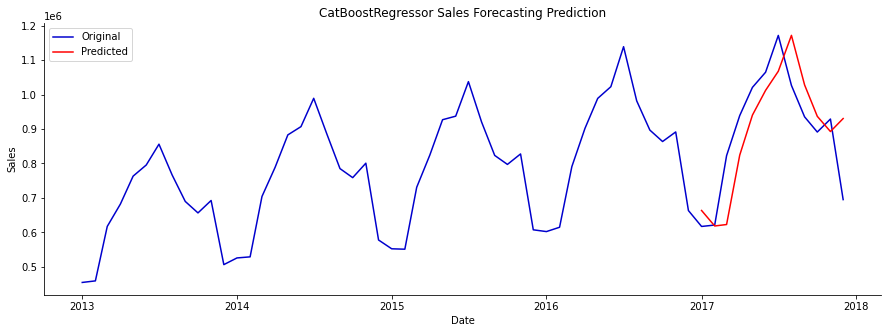

In [40]:
run_model(train, test, CatBoostRegressor(objective='RMSE', 
                                         max_depth= 12, 
                                         learning_rate= 0.03, 
                                         iterations= 100, 
                                         colsample_bylevel= 0.5, 
                                         bootstrap_type='Bernoulli', 
                                         boosting_type='Ordered'), 
          'CatBoostRegressor')#96189.41666666667